# CS 181 Practical, Spring 2023

### Import Packages

In [2]:
## Import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
# After you've installed a package, you can import it
import librosa
import pandas as pd

#import sklearn functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


### Set directories

In [4]:
# define directories
base_dir = ("/Users/brentonstefko/Desktop/Harvard/Practical")

## directory to save figures in
images_dir = '/Users/brentonstefko/Desktop/Harvard/Practical/images/'

## directory to save models in
model_dir = '/Users/brentonstefko/Desktop/Harvard/Practical/models/'

## directory to save data in
data_dir = '/Users/brentonstefko/Desktop/Harvard/Practical/data/'

os.chdir(base_dir)

### Load raw amplitude data as a numpy object.

In [5]:
# Load amplitude training and testing data
X_amp_train = np.load(data_dir + "Xtrain_amp.npy")
y_amp_train = np.load(data_dir + "ytrain_amp.npy")
X_amp_test = np.load(data_dir + "Xtest_amp.npy")
y_amp_test = np.load(data_dir + "ytest_amp.npy")

In [6]:
X_amp_train.shape

(5553, 44100)

In [7]:
X_amp_test.shape

(2197, 44100)

### Load mel spectrogram data as a numpy object.

In [8]:
# Load mel spectogram training and testing data

X_mel_train = np.load(data_dir + "Xtrain_mel.npy")
y_mel_train = np.load(data_dir + "ytrain_mel.npy")
X_mel_test = np.load(data_dir + "Xtest_mel.npy")
y_mel_test = np.load(data_dir + "ytest_mel.npy")

In [9]:
# Flatten X_mel's spectrogram features
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
X_mel_test_flat = X_mel_test.reshape(X_mel_test.shape[0], -1)
print(X_mel_train.shape)
print(X_mel_train_flat.shape)

(5553, 128, 87)
(5553, 11136)


### Set up Model/Figure Saving

In [10]:
## Load Models

os.chdir(model_dir)

## baseline amplitude model
with open("logit_amp_base", "rb") as f:
  logit_amp_base = pickle.load(f)

## baseline logit model
with open("logit_mel_base", 'rb') as f:
  logit_mel_base = pickle.load(f)

# Logit Search
with open("logit_mel_search", "rb") as f:
  logit_mel_search = pickle.load(f)

# Logit Opt
with open("logit_mel_opt", "rb") as f:
  logit_mel_opt = pickle.load(f)

# KNN base
with open("knn_mel_base", "rb") as f:
  knn_mel_base = pickle.load(f)

# KNN search
with open("knn_mel_search", "rb") as f:
  knn_mel_search = pickle.load(f)

# KNN opt
with open("knn_mel_opt", "rb") as f:
  knn_mel_opt = pickle.load(f)


# Models AMP STD
with open("models_amp_std_list", "rb") as f:
  models_amp_std_list = pickle.load(f)


# Models MEL STD
with open("models_mel_std_list", "rb") as f:
  models_mel_std_list = pickle.load(f)


# KNN STD 
with open("knn_mel_std", "rb") as f:
  knn_mel_std = pickle.load(f)

# Models KNN STD Search
with open("knn_mel_std_search", "rb") as f:
  knn_mel_std_search = pickle.load(f)

# Optimal KNN Std model
with open("knn_mel_std_opt", "rb") as f:
  knn_mel_std_opt = pickle.load(f)


##### Load in Data that takes time to run
with open("data_pca", "rb") as f:
  data_pca = pickle.load(f)


/Users/brentonstefko/miniforge3/envs/practical_personal/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/brentonstefko/miniforge3/envs/practical_personal/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/brentonstefko/miniforge3/envs/practical_personal/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentV

# Beginning of Project
### CS 181 Practical, Spring 2021
### Author: Brenton Stefko


## Overview


1.   Understand the shape of the data
1.   Data Cleaning
1. Data Exploration




### Amplitude Data 
* Is a 5553 x 44100 (N x D) dataset
* Each observation corresponds to a sound recording of a given category
* The 2nd dimension corresponds to the each timestep of the recording
* The data are the sampled signal amplitudes at each timestep


In [11]:
print(X_amp_train.shape)

(5553, 44100)


### Mel Spectogram Data
* Spectogram is a representation of the frequencies of a signal as it varies over time
* For each observation, the time dimension is partitioned into 87 sub sequences
* The Mel Spectogram data represents the presence of 128 frequencies in the 87 sub-sequences
* Flattening the dataset results in a 5553 x 11136 dataset with each column representing a given frequency - sub sequence combination


In [12]:
# print dimension of X_mel_train
print(X_mel_train.shape)

(5553, 128, 87)


In [13]:
# print dimension of X_mel_train_flat
print(X_mel_train_flat.shape)

(5553, 11136)


### Descriptive Analysis
* Want to understand the distribution of the amplitude and frequencies 
> In particular: Do these distributions differ by category? Plot Histograms, Boxplots for each category
* Are there any outliers in the data that might be worth trimming?
* Are there missing values present in the data, and how should we treat these?
> E.g., we could replace a missing with the column mean of the affected category

## Plots:
1. Time Series Plot plotting the average for each category at any given point in time +- 2 SD
> This should give a good idea of the data
<br>
> It will be necessary to reduce data to a certain extent: Split the time dimension into intervals and then get the average for each interval/category combination


In [14]:
# Get frequencies of different categories in amplitude data
unique_amp, counts_amp = np.unique(y_amp_train, return_counts = True)
print(np.asarray((unique_amp, counts_amp)).T)

[[  0 700]
 [  1 197]
 [  2 696]
 [  3 523]
 [  4 607]
 [  5 721]
 [  6  83]
 [  7 658]
 [  8 668]
 [  9 700]]


In [15]:
# Get frequencies of different categories in spectogram data
unique_mel, counts_mel = np.unique(y_mel_train, return_counts = True)
print(np.asarray((unique_mel, counts_mel)).T)

[[  0 700]
 [  1 197]
 [  2 696]
 [  3 523]
 [  4 607]
 [  5 721]
 [  6  83]
 [  7 658]
 [  8 668]
 [  9 700]]


In [16]:
## Get a dictionary for each category seperately

cat_data = {}
cat_data_mel = {}

def get_cat_data(name, index):
  X_amp_train_cat = X_amp_train[y_amp_train == index, :]
  return(X_amp_train_cat)

def get_cat_data_mel(name, index):
  X_mel_train_cat = X_mel_train_flat[y_mel_train == index, :]
  return(X_mel_train_cat)

cat_dict = {0:"AC", 1:"Car Horn", 2:"Child", 3:"Dog", 4:"Drill", 5:"Engine", 6:"Gun", 7:"Jackhammer", 8:"Siren", 9:"Music"}

for index, name  in cat_dict.items():
  X_data = get_cat_data(name, index)
  X_data_mel = get_cat_data_mel(name, index)
  cat_data['{}'.format(name)] = X_data
  cat_data_mel['{}'.format(name)] = X_data_mel


In [17]:
# Reduce each of the arrays in the dictionary to 441 time periods
cat_data_means = {}
cat_data_means_mel = {}
cat_data_std = {}
names = ["AC", "Car Horn", "Child", "Dog", "Drill", "Engine", "Gun", "Jackhammer", "Siren", "Music"]


def get_reduced_data(arr, step):

  # Initiate variables
  X_init = arr[:, 0:step]
  X_mean = np.mean(X_init).reshape(-1, 1)
  X_std = np.std(X_init).reshape(-1, 1)

  for j in range(step, arr.shape[1], step):
    X_next = arr[:, j:(j+step)]
    mean_next = np.mean(X_next).reshape(-1, 1)
    std_next = np.std(X_next).reshape(-1, 1)

    # append the values to the final data
    X_mean = np.concatenate((X_mean, mean_next), axis = 0)
    X_std = np.concatenate((X_std, std_next), axis = 0)

  return(X_mean, X_std)

for name in names:
  cat_mean, cat_std = get_reduced_data(cat_data[name], 50)
  cat_mean_mel, _ = get_reduced_data(cat_data_mel[name], 50)
  cat_data_means['{}'.format(name)] = cat_mean
  cat_data_std['{}'.format(name)] = cat_std
  cat_data_means_mel['{}'.format(name)] = cat_mean_mel


1.8013976 25.229832


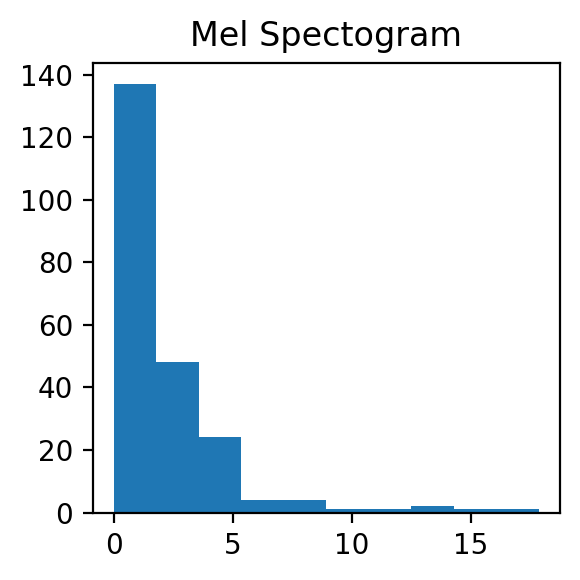

In [18]:
## Mel Spectogram Data
print(X_mel_train_flat.mean(), X_mel_train_flat.std())
mel_train_hist, _ = get_reduced_data(X_mel_train_flat, 50)

# plot histogram of mel spectogram data
plt.figure(figsize=(3, 3), dpi=200)
plt.hist(mel_train_hist)
plt.title('Mel Spectogram')

plt.tight_layout()
plt.savefig(f"{images_dir}/mel_spectogram_hist.pdf")
plt.show()

7.65894e-05 0.09457994


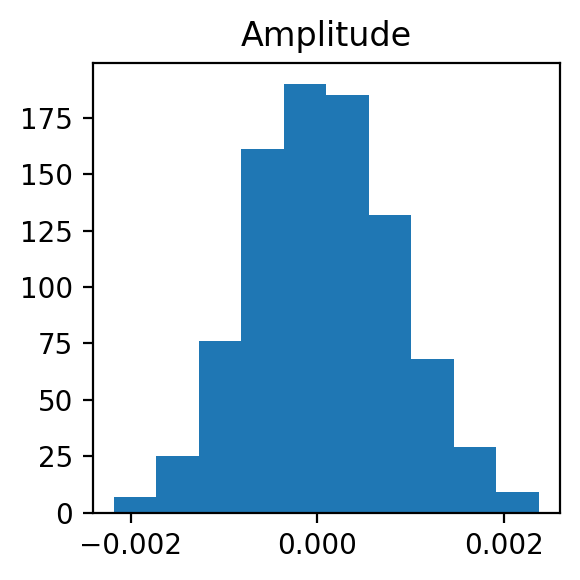

In [19]:
## Amplitude Data
print(X_amp_train.mean(), X_amp_train.std())
amp_hist, _ = get_reduced_data(X_amp_train, 50)

# plot histogram of mel spectogram data
plt.figure(figsize=(3, 3), dpi=200)
plt.hist(amp_hist)
plt.title('Amplitude')

plt.tight_layout()
plt.savefig(f"{images_dir}/amplitude_overall_hist.pdf")
plt.show()

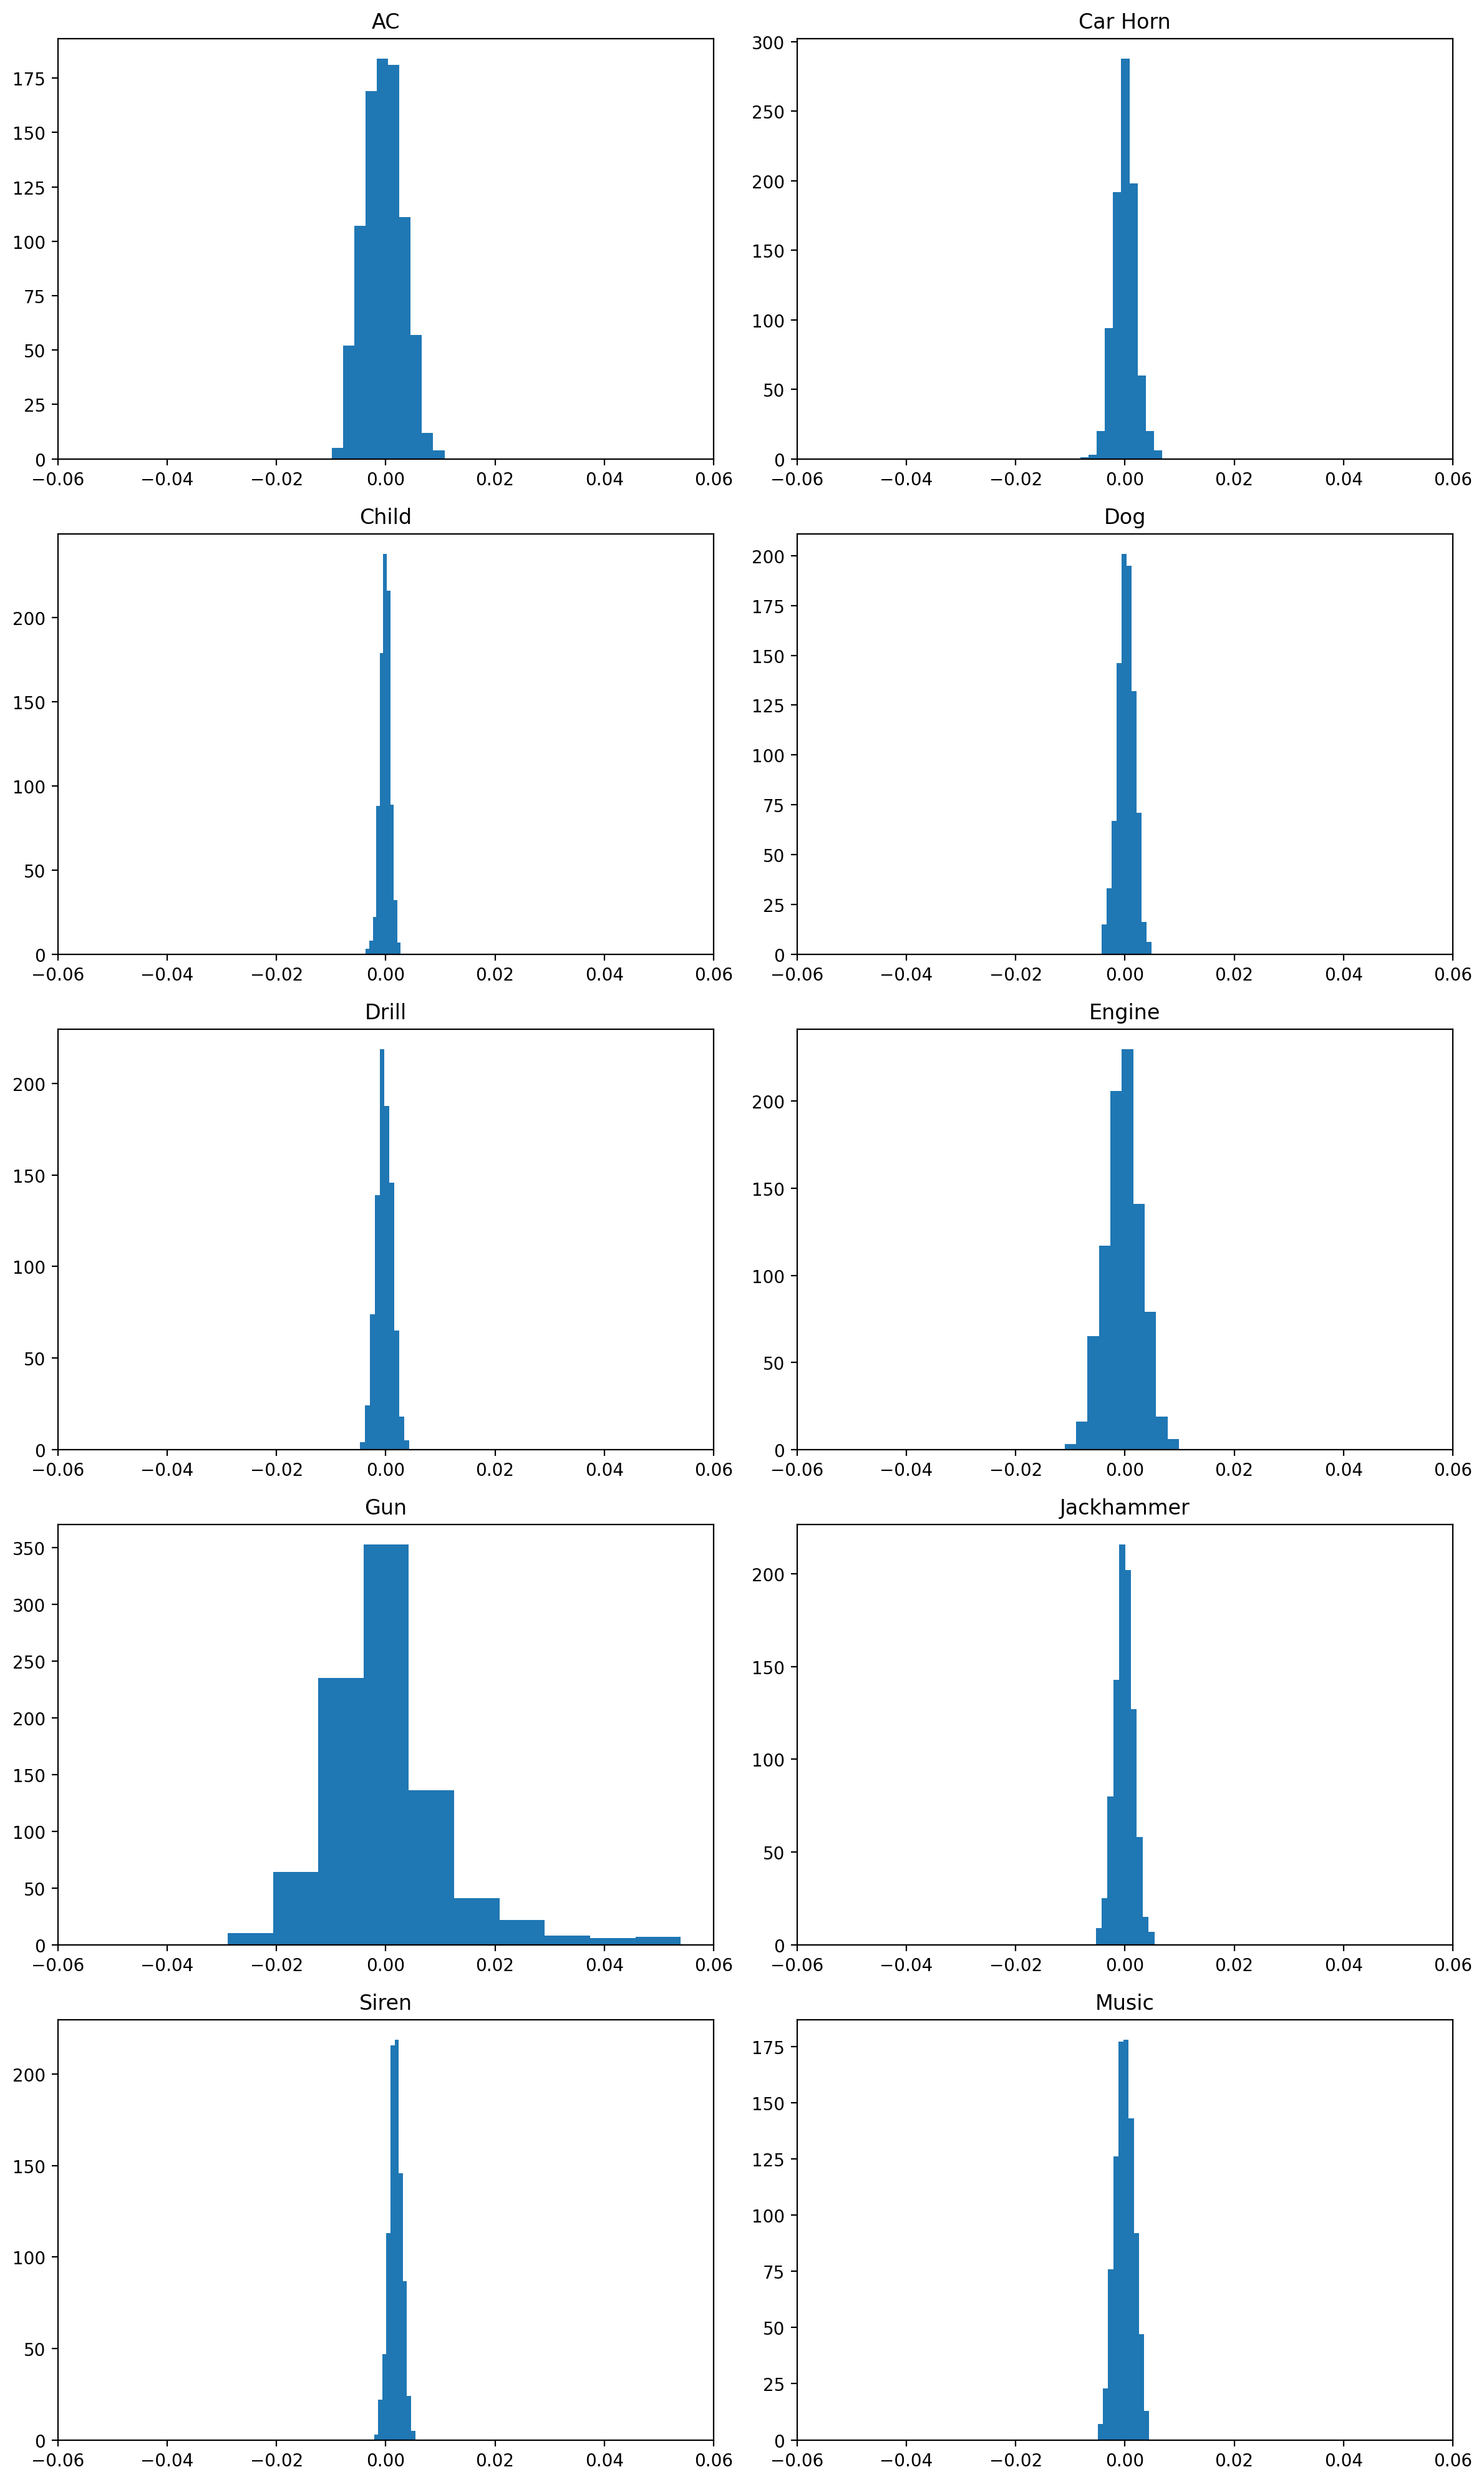

In [20]:
## Get chart with histograms for each label
# first, we tell matplotlib to start a new figure
plt.figure(figsize=(12, 20), dpi=200)

i = 0

# loop through categories
for name in names:
  
  # iterate on chart index (starts at 1 for matplotlib)
  i = i + 1

  # add subplot to figure 
  # this tells matplotlib to add a subplot to our figure (5 rows, 2 cols)
  plt.subplot(5, 2, i)
  
  # plot histogram
  plt.hist(cat_data_means[name])

  # Set the range of x-axis
  plt.xlim(-0.06, 0.06)
  
  # add in the label + title
  plt.title(name)

plt.tight_layout()
plt.savefig(f"{images_dir}/histograms.pdf")
plt.show()



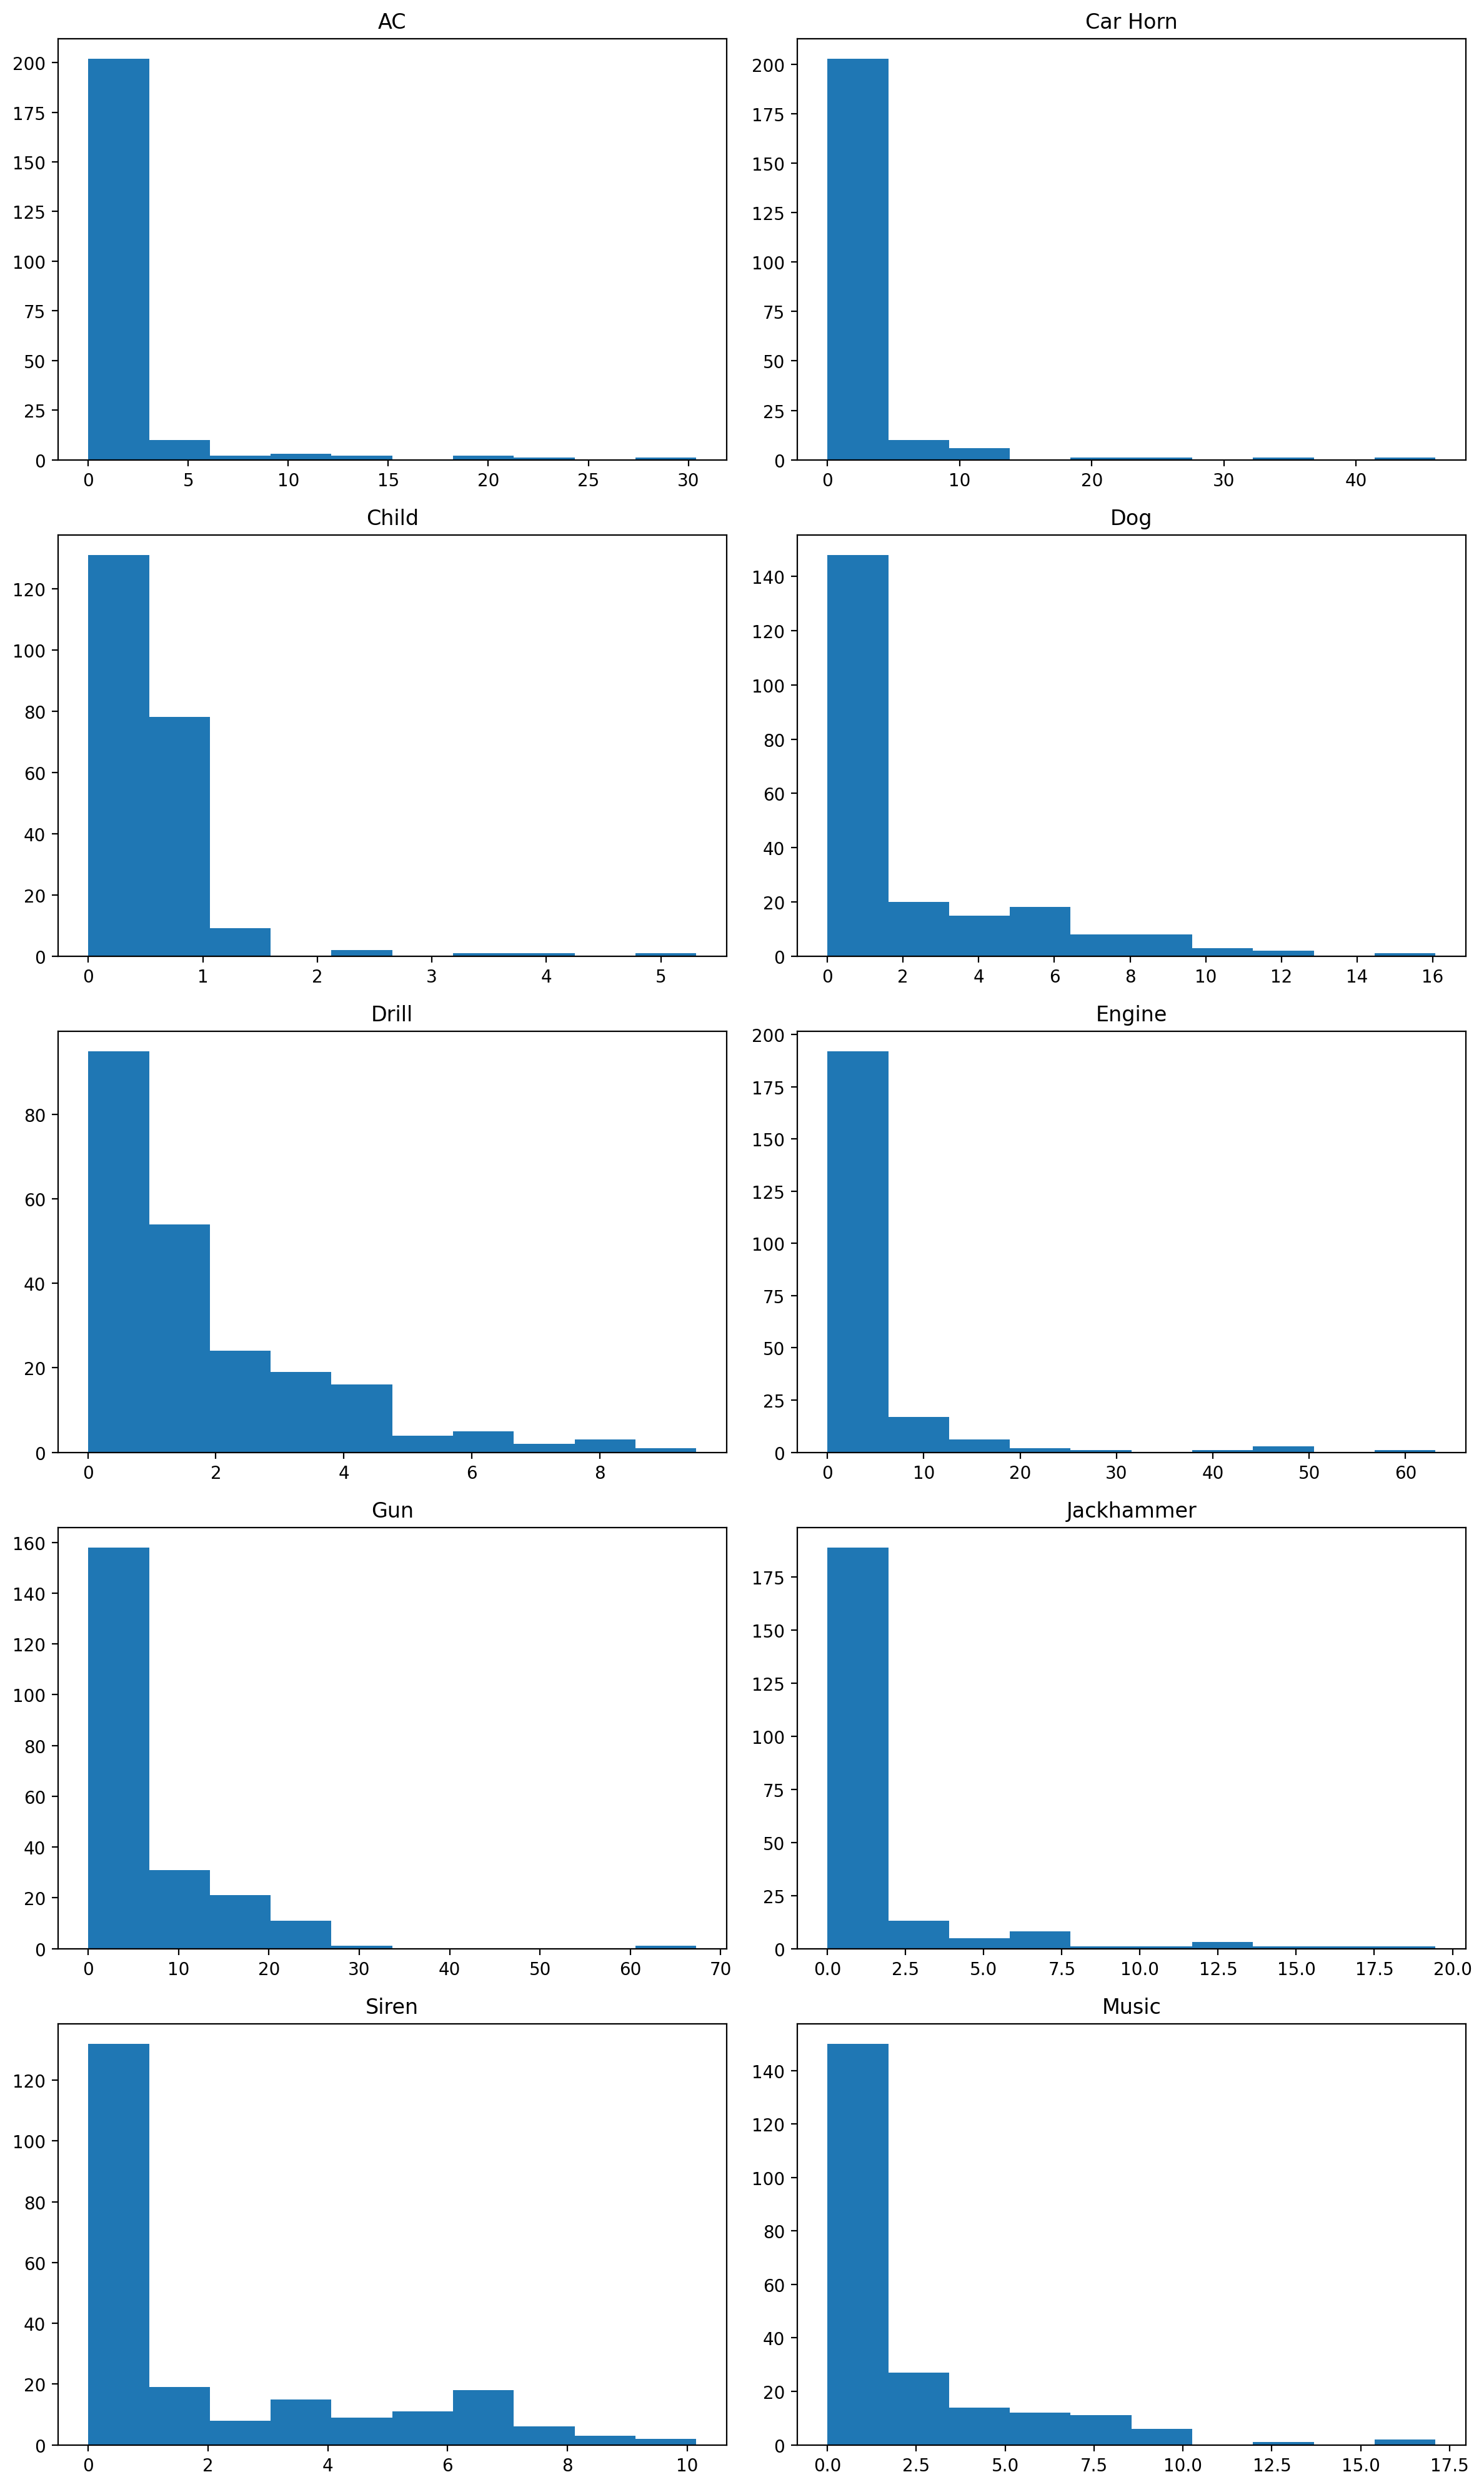

In [21]:
## Get chart with histograms for each label
# first, we tell matplotlib to start a new figure
plt.figure(figsize=(12, 20), dpi=200)

i = 0

# loop through categories
for name in names:
  
  # iterate on chart index (starts at 1 for matplotlib)
  i = i + 1

  # add subplot to figure 
  # this tells matplotlib to add a subplot to our figure (5 rows, 2 cols)
  plt.subplot(5, 2, i)
  
  # plot histogram
  plt.hist(cat_data_means_mel[name])

  # Set the range of x-axis
  #plt.xlim(-0.06, 0.06)
  
  # add in the label + title
  plt.title(name)

plt.tight_layout()
plt.savefig(f"{images_dir}/histograms_mel_by_cat.pdf")
plt.show()



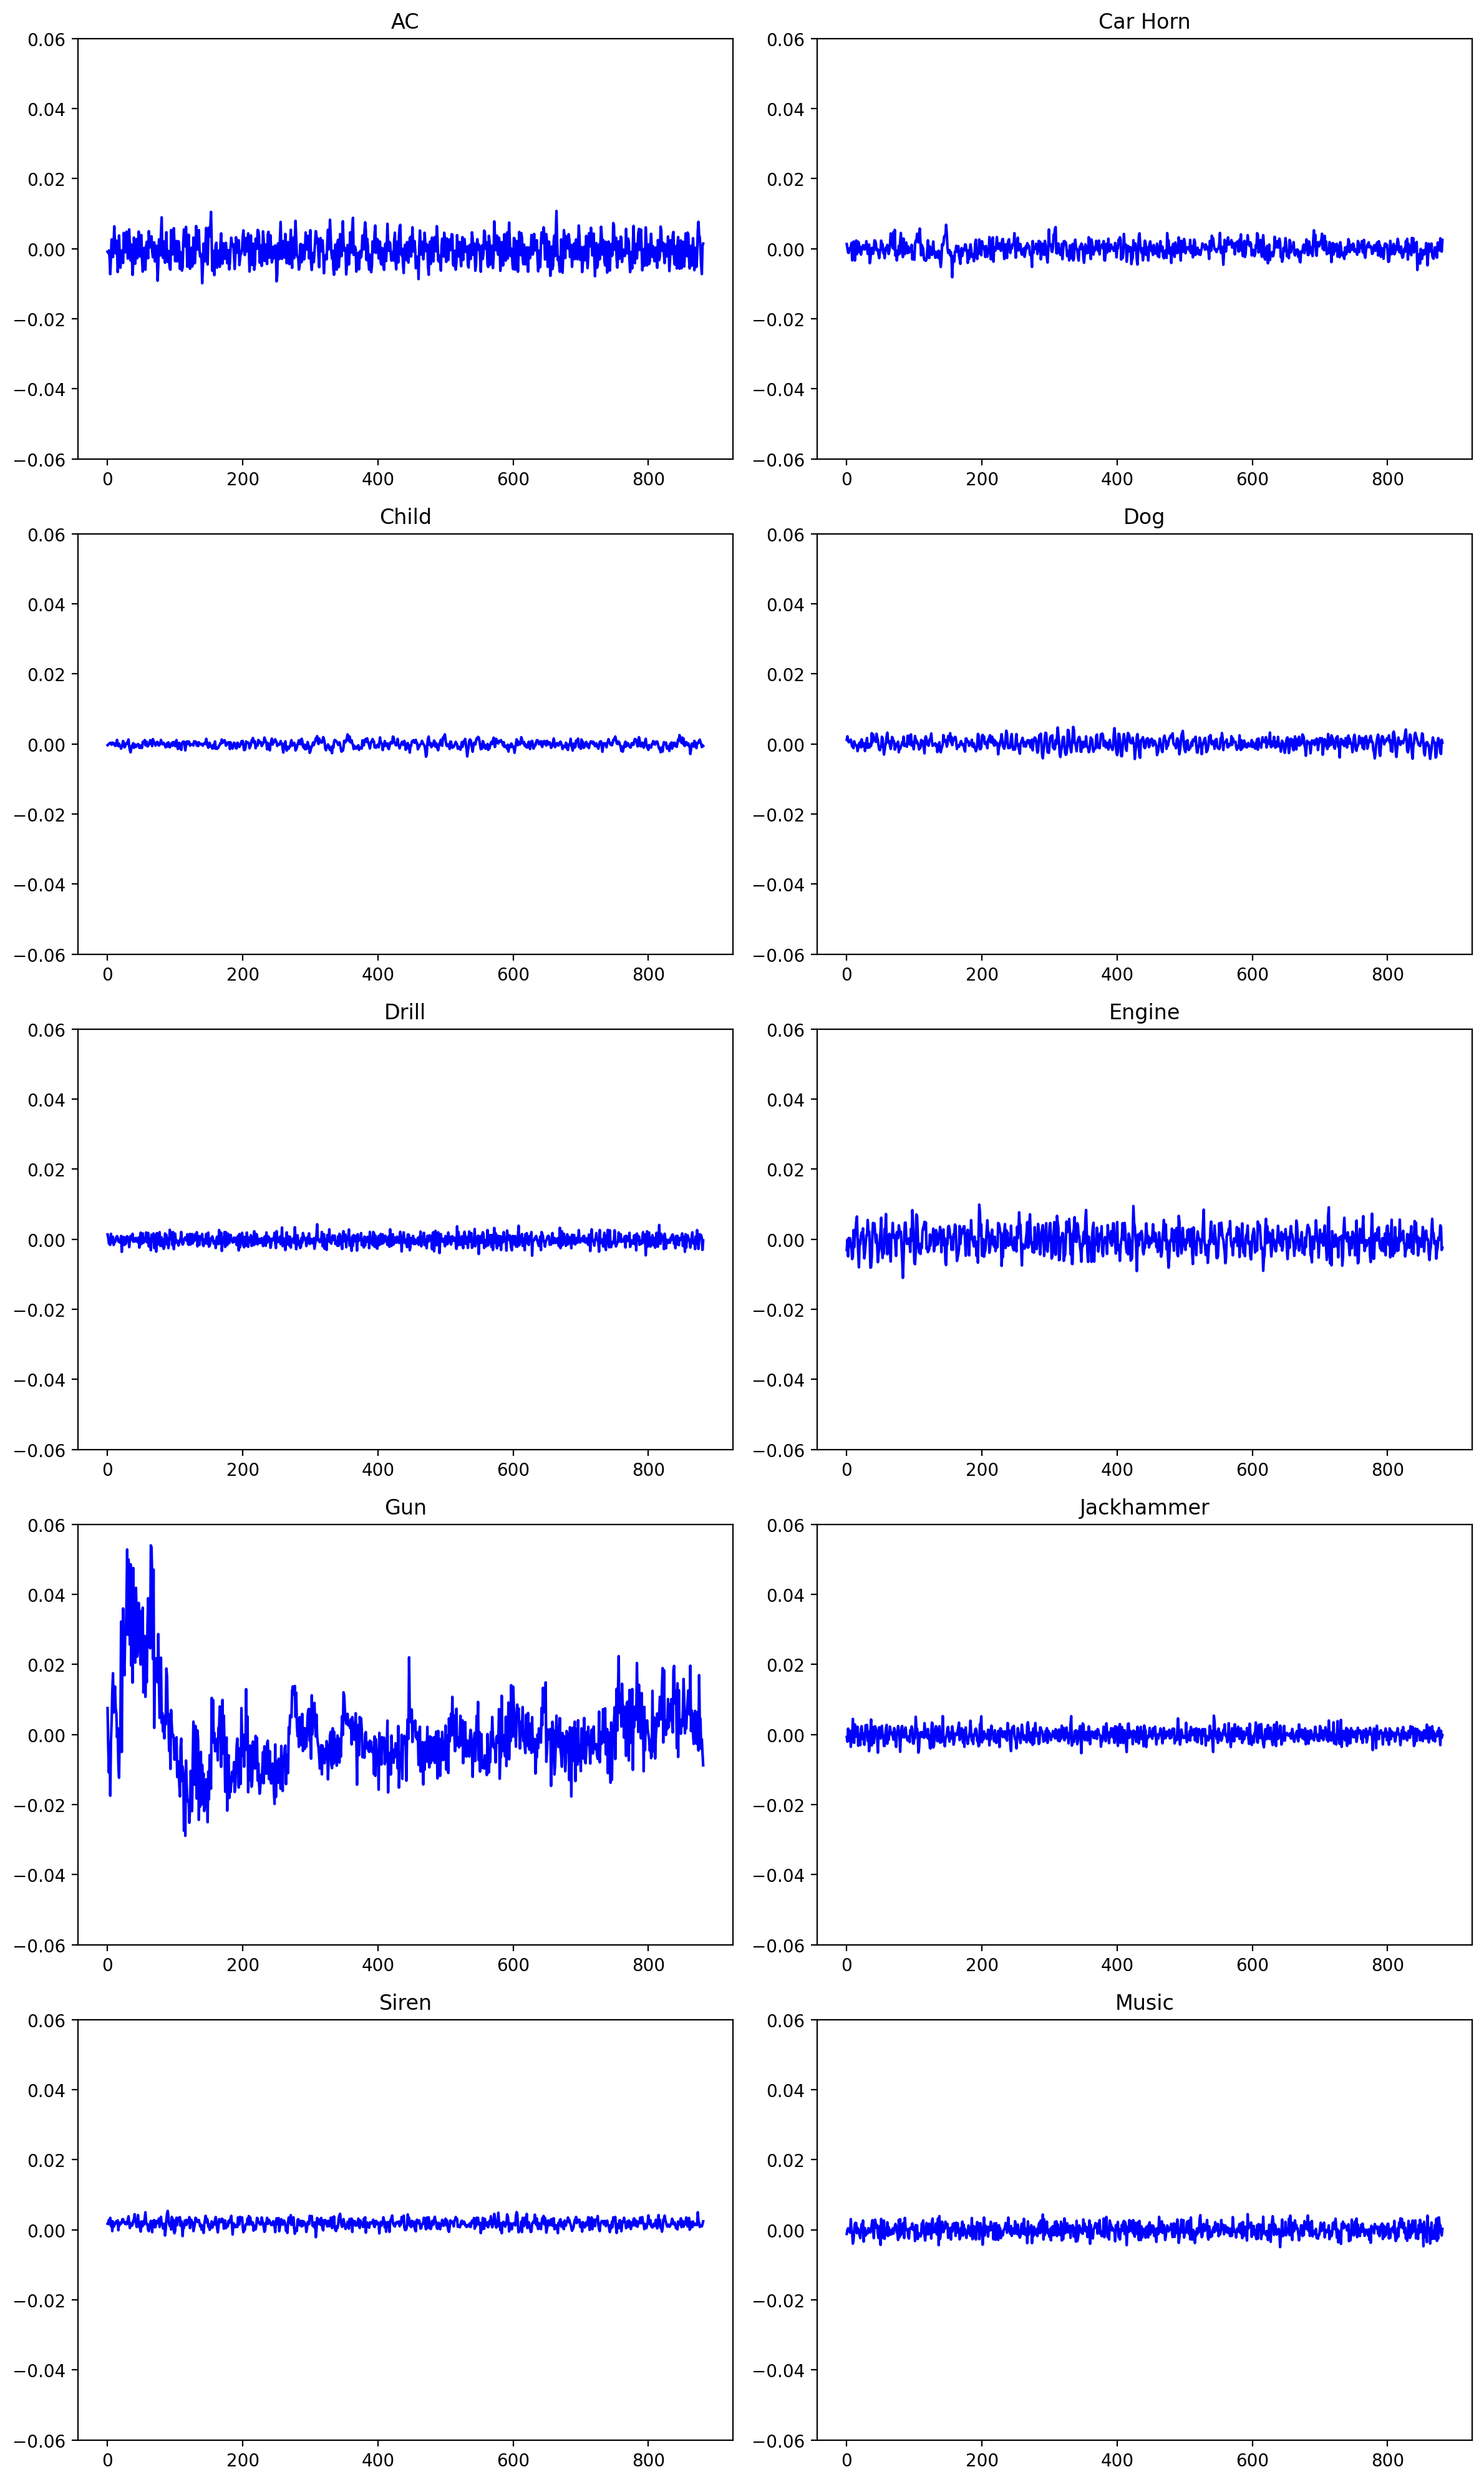

In [22]:
# Generate a line chart for each category
# first, tell matplotlib to start a new figure
plt.figure(figsize=(12, 20), dpi=200)

i = 0

# the odd thing is that in this type of subplot, matplotlib starts counting from 1, as opposed to 0.
for name in names:
  
   # iterate on chart index (starts at 1 for matplotlib)
  i = i + 1

  # add subplot to figure 
  # this tells matplotlib to add a subplot to our figure (5 rows, 2 cols)
  plt.subplot(5, 2, i)
  
  # line plot
  plt.plot(cat_data_means[name], color= "blue", label ="mean")

  #get y limit
  plt.ylim(-0.06, 0.06)
  
  # add in the label + title
  plt.title(name)

plt.tight_layout()
plt.savefig(f"{images_dir}/time-series.pdf")
plt.show()

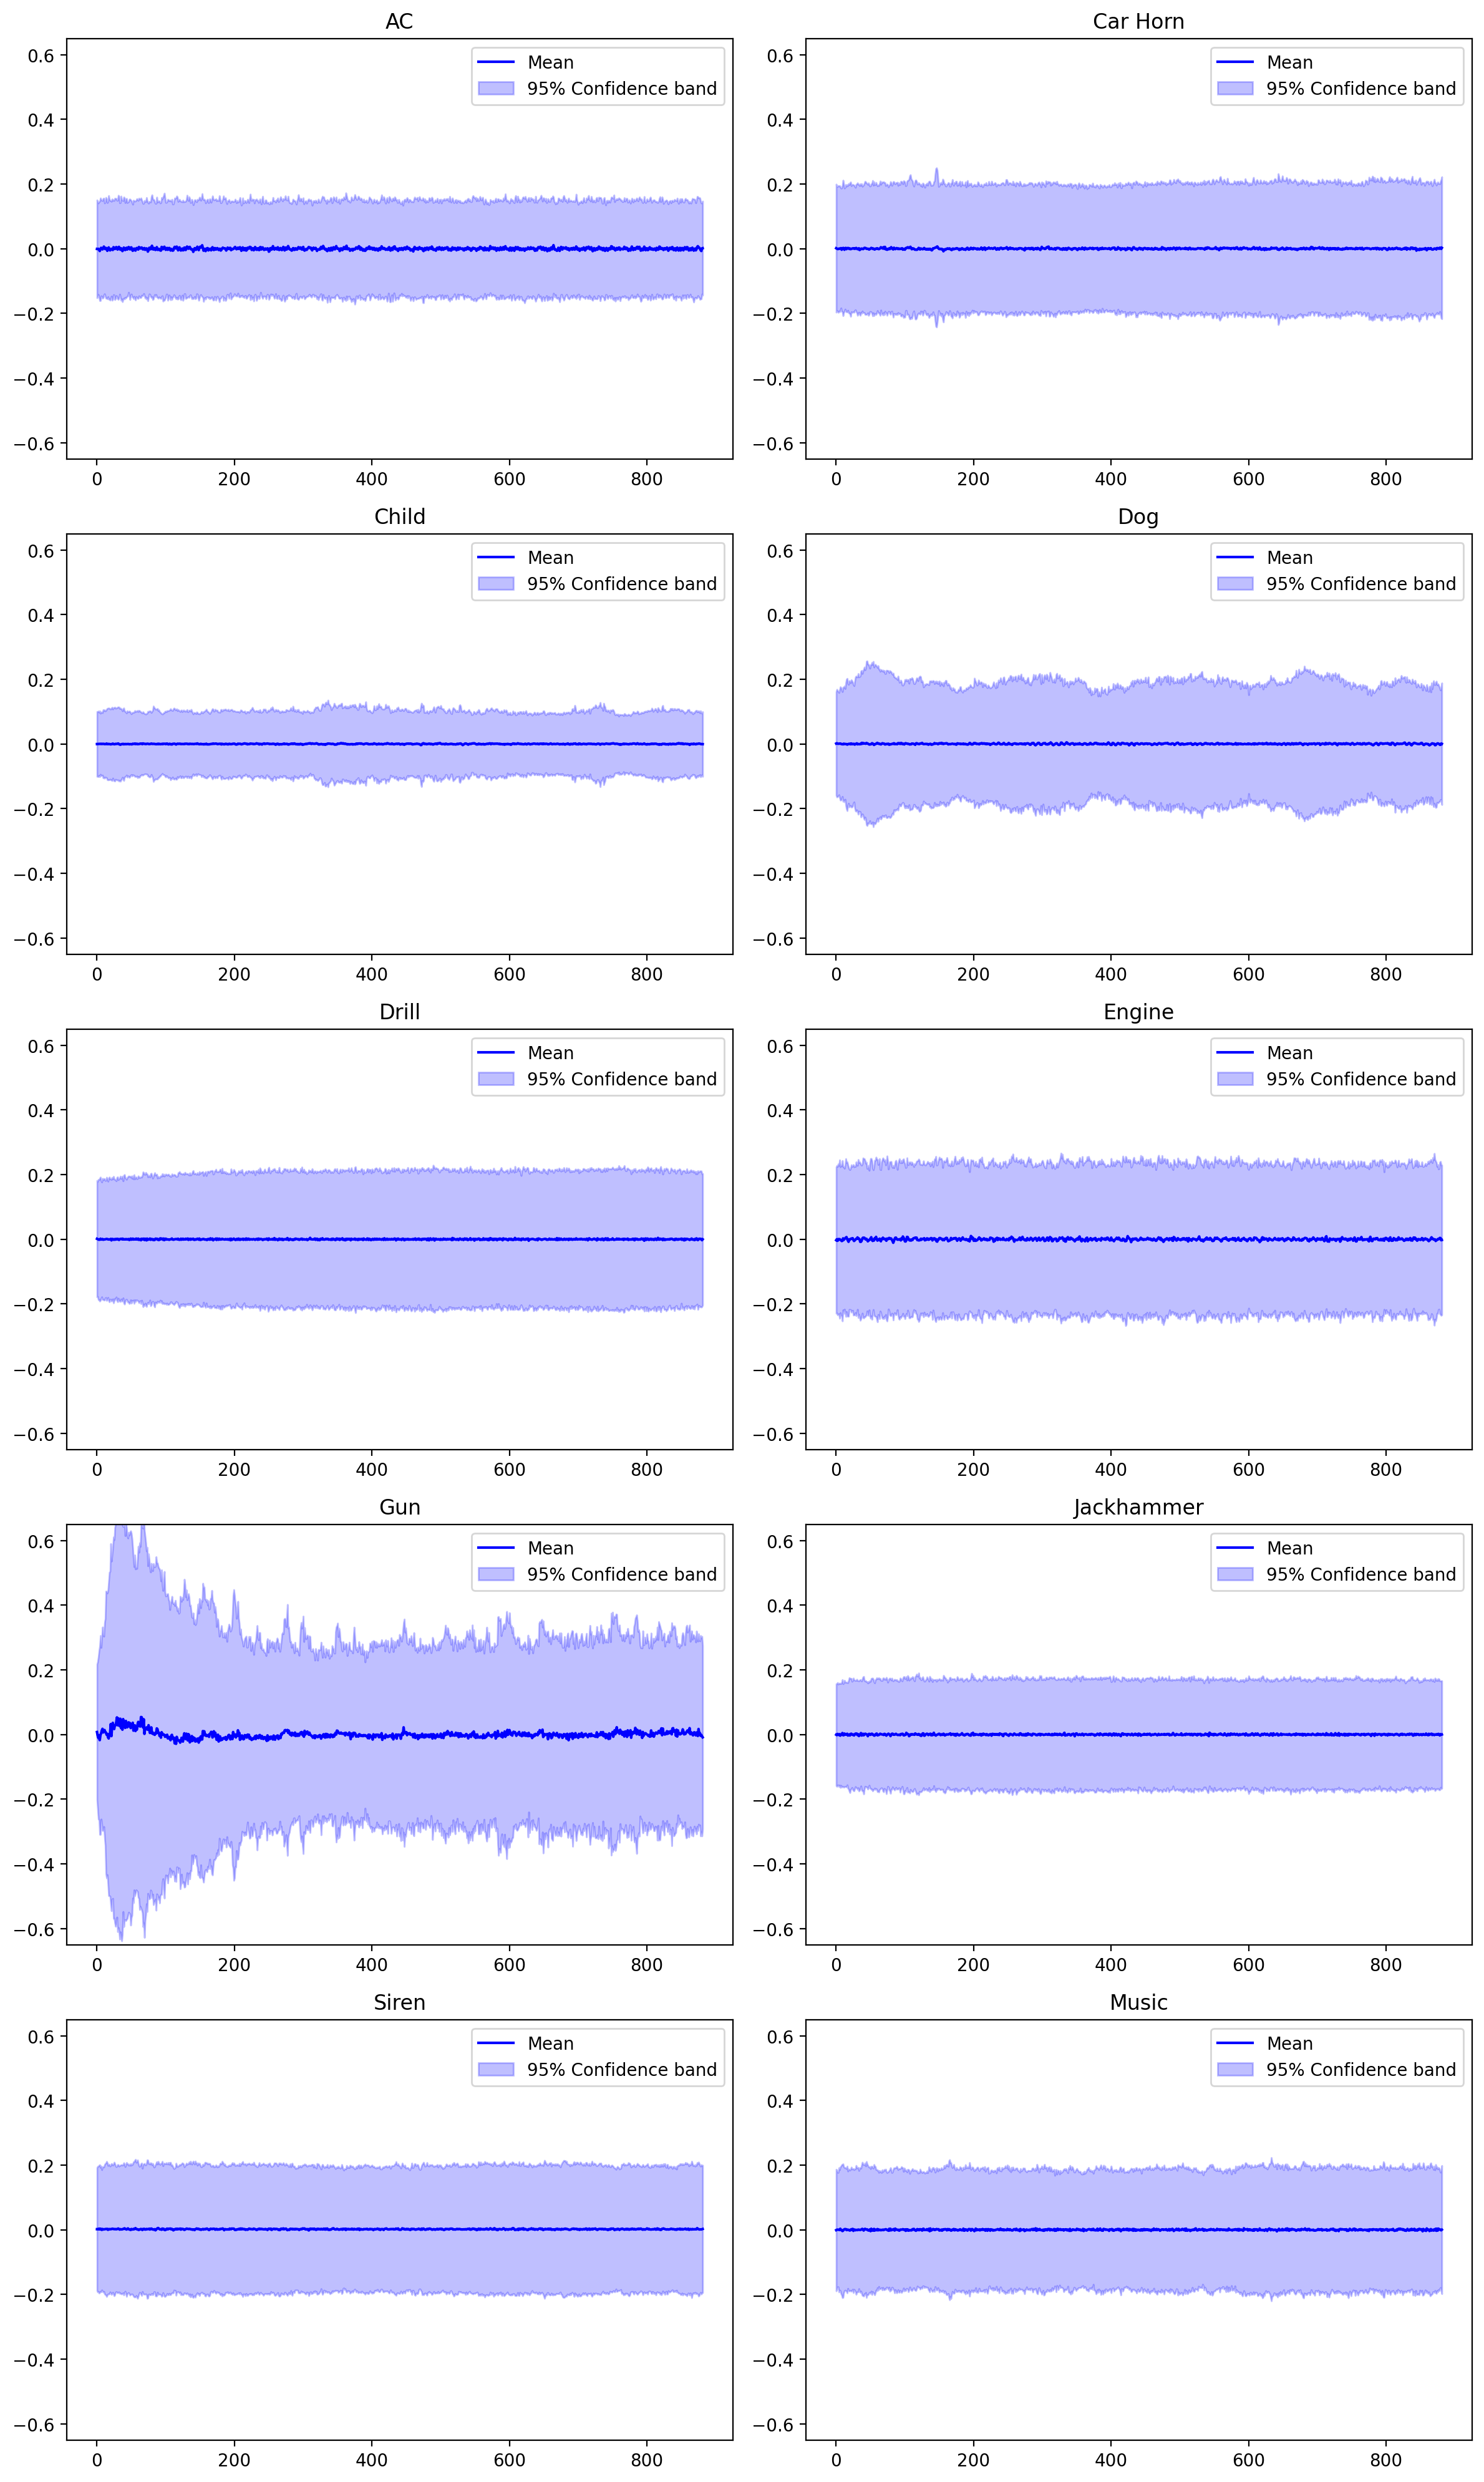

In [23]:
## Generate area plots with 95% Confidence interval

# need an array for the x-axis
x_axis = np.arange(0, cat_data_means['AC'].shape[0])

# function to get the upper and lower bounds for the area plot
def get_bounds(name):
  up = cat_data_means[name] + 2*cat_data_std[name]
  low = cat_data_means[name] - 2*cat_data_std[name]
  mean = cat_data_means[name]
  up = up.ravel("F")
  low = low.ravel("F")
  mean = mean.ravel("F")
  return(up, low, mean)


# first, tell matplotlib to start a new figure
plt.figure(figsize=(12, 20), dpi=200)

i = 0

# the odd thing is that in this type of subplot, matplotlib starts counting from 1, as opposed to 0.
for name in names:

  # iterate on chart index (starts at 1 for matplotlib)
  i = i + 1

  # get upper and lower bounds
  up, low, mean = get_bounds(name)

  # add subplot to figure 
  # this tells matplotlib to add a subplot to our figure (5 rows, 2 cols)
  plt.subplot(5, 2, i)
  
  # ylim
  plt.ylim(-0.65, 0.65)
  
  # Plot lines
  plt.plot(x_axis, mean, color = "blue", label = "Mean")

  # Fill area between upper and lower
  plt.fill_between(
      x_axis, up, low, interpolate=True, color="blue", alpha=0.25, label="95% Confidence band"
  )

    
  # add in the label + title
  plt.title(name)
  plt.legend();

plt.tight_layout()
plt.savefig(f"{images_dir}/CI.pdf")
plt.show()


## Display Mel Spectogram

[Text(0.5, 1.0, 'Mel-frequency spectrogram, Child')]

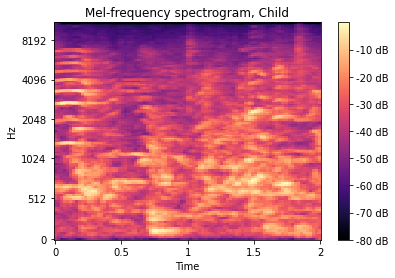

In [24]:
#print(X_mel_train[0])
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(X_mel_train[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram, ' + names[y_mel_train[0]])

[Text(0.5, 1.0, 'Mel-frequency spectrogram, AC')]

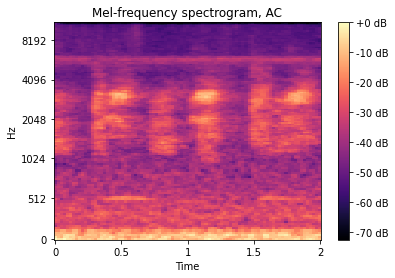

In [25]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(X_mel_train[1], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram, ' + names[y_mel_train[1]])

[Text(0.5, 1.0, 'Mel-frequency spectrogram, Jackhammer')]

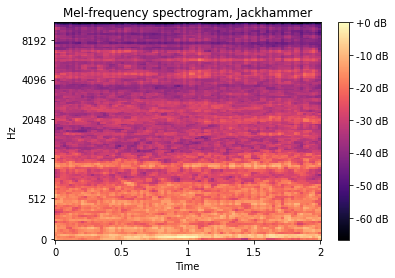

In [26]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(X_mel_train[6], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram, ' + names[y_mel_train[6]])

## Histograms of overall distributions

# Logistic Regression Models

### Baseline Models
1. Train a logistic regression model (without regularization) on the raw Amplitude data
1. Train a logistic regression model (without regularizartion) on the raw Mel Spectogram data

### Include Feature Engineering on these Datasets
1. Standardize the individual features ()
1. Transform using principal component analysis
1. Maybe: Standardize Data

### Use GridsearchCV to tune hyperperameters (only one feature representation)
1. L1, L2 Regularization
1. Different regularization strengths
1. Perform this on the raw data, the quadratic data, and PCA data 

### For each of the models:
* Compute Training/Testing Accuracy
* Compute AUC Score
* Plot ROC Curve for the initial logistic regressions and for the best-performing model
* After finding the model that performs best among the ones you tried, consider reweighting the data to boost performance among the classes that did not perform well


### Prerequisite Functions

In [27]:
## Define a function to get ROC Data and Curve

# Inputs are X_test, y_test, model

def get_ROC(X_test, y_test, model, figname):

  ## Get Data for ROC curve (matrix of probabilities, one-hot encoded y-test)
  probs = model.predict_proba(X_test)
  label_binarizer = LabelBinarizer().fit(y_test)
  y_onehot_test = label_binarizer.transform(y_test)

  ## Calculate ROC Score
  micro_roc_auc_ovr = roc_auc_score(
      y_test,
      probs,
      multi_class="ovr",
      average="micro",
  )

  print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

  # dictionary defining labels and colors
  label_dict = {0:("AC","royalblue"), 1:("Car Horn","darkorange"), 2:("Child","darkgrey"), 3:("Dog","magenta"), 
              4:("Drill","gold"), 5:("Engine","lawngreen"), 6:("Gun", "teal"), 7:("Jackhammer", "dimgrey"), 8:("Siren","firebrick"), 9:("Music", "pink")}

  fig, ax = plt.subplots(figsize=(8, 8), dpi = 100)


  for class_id, specs in label_dict.items():
    name = specs[0]
    color = specs[1]
    RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      probs[:, class_id],
      name=f"{name}",
      color=color,
      ax = ax,
  )
    
  RocCurveDisplay.from_predictions(
      y_onehot_test.ravel(),
      probs.ravel(),
      name="Average OvR",
      color="darkviolet",
      ax = ax,
  )

  plt.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves")
  plt.legend()
  plt.savefig(f"{images_dir}/{figname}.pdf")
  plt.show()

In [28]:

cat_dict = {0:"AC", 1:"Car Horn", 2:"Child", 3:"Dog", 4:"Drill", 5:"Engine", 6:"Gun", 7:"Jackhammer", 8:"Siren", 9:"Music"}

def per_class_accuracy(X_train, y_train, X_test, y_test, model):

  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  train_accuracies = {}
  test_accuracies = {}

  for num, label in cat_dict.items():
    class_train_preds = train_preds[y_train == num]
    class_test_preds = test_preds[y_test == num]

    corr_train_preds = class_train_preds[class_train_preds == num].shape[0]
    corr_test_preds = class_test_preds[class_test_preds == num].shape[0]

    train_accuracies[label] = corr_train_preds/class_train_preds.shape[0]
    test_accuracies[label] = corr_test_preds/class_test_preds.shape[0]
  
  # print result
  for label, _ in train_accuracies.items():
    print(f"{label}; Train Accuracy: {train_accuracies[label]:.2f}; Test Accuracy: {test_accuracies[label]:.2f}")

In [29]:
def eval_scores(X_train, y_train, X_test, y_test, model):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Train Accuracy:\n{train_score:.2f}")
    print(f"Test Accuracy:\n{test_score:.2f}")   

In [30]:
def get_results(X_train, y_train, X_test, y_test, model, ROC_figname):

    print("Overall Evaluation Metrics:\n")
    eval_scores(X_train, y_train, X_test, y_test, model)
    print("\nPer-Class Evaluation Metrics:\n")
    per_class_accuracy(X_train, y_train, X_test, y_test, model)
    get_ROC(X_test, y_test, model, ROC_figname)

### Train a Baseline Logistic Regression Model - Amplitude Data

In [31]:
# Define a baseline logistic regression
logit_base = LogisticRegression(penalty = None, max_iter = 1000, 
                                    fit_intercept = True, multi_class = 'multinomial', solver = 'lbfgs')

In [32]:
'''
# Baseline logistic regression using amplitude data
logit_amp_base = logit_base.fit(X_amp_train, y_amp_train)

# Save Model
with open ("logit_amp_base", "wb") as f:
  pickle.dump(logit_amp_base, f)
'''

'\n# Baseline logistic regression using amplitude data\nlogit_amp_base = logit_base.fit(X_amp_train, y_amp_train)\n\n# Save Model\nwith open ("logit_amp_base", "wb") as f:\n  pickle.dump(logit_amp_base, f)\n'

Overall Evaluation Metrics:

Train Accuracy:
1.00
Test Accuracy:
0.17

Per-Class Evaluation Metrics:

AC; Train Accuracy: 1.00; Test Accuracy: 0.23
Car Horn; Train Accuracy: 1.00; Test Accuracy: 0.08
Child; Train Accuracy: 1.00; Test Accuracy: 0.17
Dog; Train Accuracy: 1.00; Test Accuracy: 0.15
Drill; Train Accuracy: 1.00; Test Accuracy: 0.03
Engine; Train Accuracy: 1.00; Test Accuracy: 0.27
Gun; Train Accuracy: 1.00; Test Accuracy: 0.07
Jackhammer; Train Accuracy: 1.00; Test Accuracy: 0.09
Siren; Train Accuracy: 1.00; Test Accuracy: 0.28
Music; Train Accuracy: 1.00; Test Accuracy: 0.14
Micro-averaged One-vs-Rest ROC AUC score:
0.55


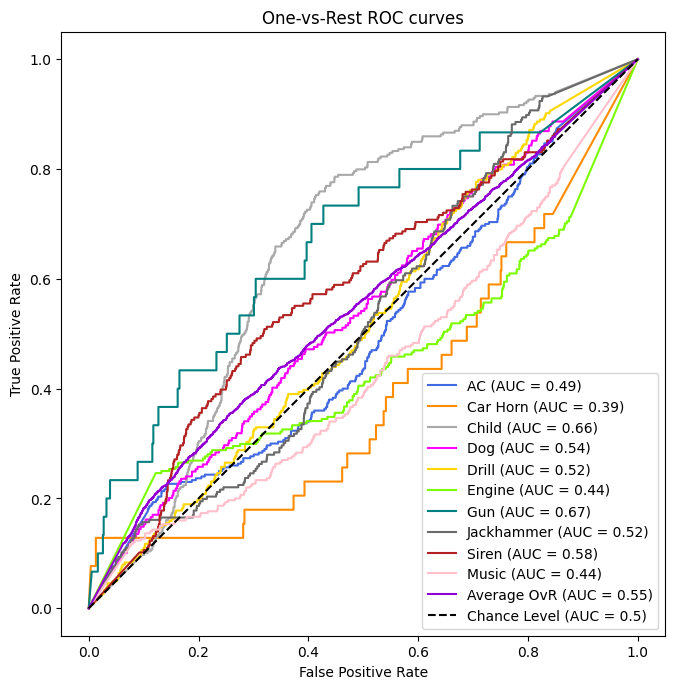

In [33]:
## Get classification results
get_results(X_amp_train, y_amp_train, X_amp_test, y_amp_test, logit_amp_base, 'ROC_baseline_amp')

### Train a Baseline Logistic Regression Model - Mel Spectogram Data

In [34]:
'''
# Baseline logistic regression using mel spectogram data
logit_mel_base = logit_base.fit(X_mel_train_flat, y_mel_train)

# Save Model
with open ("logit_mel_base", "wb") as f:
  pickle.dump(logit_mel_base, f)
'''

'\n# Baseline logistic regression using mel spectogram data\nlogit_mel_base = logit_base.fit(X_mel_train_flat, y_mel_train)\n\n# Save Model\nwith open ("logit_mel_base", "wb") as f:\n  pickle.dump(logit_mel_base, f)\n'

Overall Evaluation Metrics:

Train Accuracy:
0.97
Test Accuracy:
0.36

Per-Class Evaluation Metrics:

AC; Train Accuracy: 0.97; Test Accuracy: 0.26
Car Horn; Train Accuracy: 0.99; Test Accuracy: 0.36
Child; Train Accuracy: 0.94; Test Accuracy: 0.21
Dog; Train Accuracy: 0.94; Test Accuracy: 0.19
Drill; Train Accuracy: 0.99; Test Accuracy: 0.46
Engine; Train Accuracy: 0.97; Test Accuracy: 0.43
Gun; Train Accuracy: 1.00; Test Accuracy: 0.80
Jackhammer; Train Accuracy: 1.00; Test Accuracy: 0.44
Siren; Train Accuracy: 0.99; Test Accuracy: 0.69
Music; Train Accuracy: 0.97; Test Accuracy: 0.22
Micro-averaged One-vs-Rest ROC AUC score:
0.70


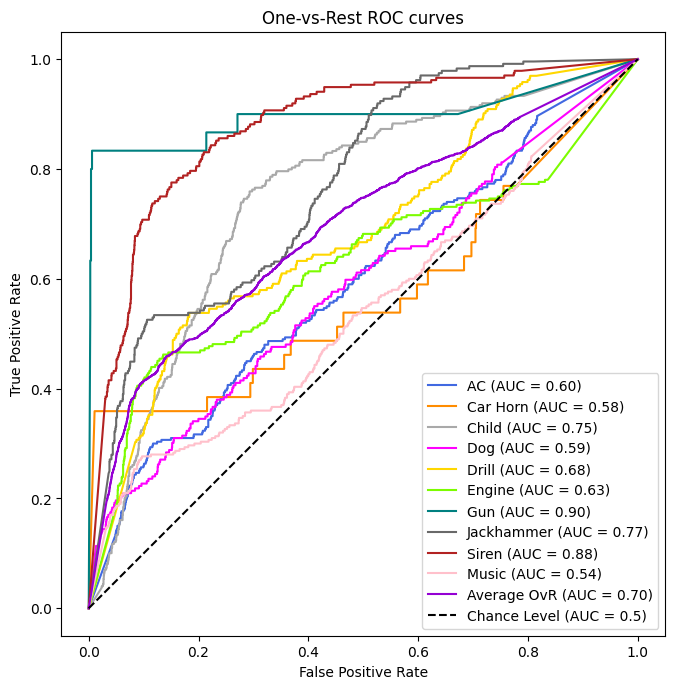

In [35]:
# Get results
get_results(X_mel_train_flat, y_mel_train, X_mel_test_flat, y_mel_test, logit_mel_base, 'ROC_baseline_mel')

### Try different standardizations of Amplitude and Mel Spectogram Data
> Get Mel Spectogram Data into format of a normal distribution

In [73]:
# Define Functions to Scale Data
# Always have to scale train and test data in the same way

def std_scaler(X_train, X_test):
  
  ## Scale data - Standard Scaler
  scaler = StandardScaler()
  scaler = scaler.fit(X_train)
  X_train_std = scaler.transform(X_train)
  X_test_std = scaler.transform(X_test)
  return(X_train_std, X_test_std)


def minmax_scaler(X_train, X_test):

  train_min = X_train.min()
  train_max = X_train.max()
  scaler = MinMaxScaler(feature_range=(train_min, train_max))
  scaler = scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return(X_train_scaled, X_test_scaled)

def pt_scaler(X_train, X_test):
  pt = PowerTransformer()
  pt = pt.fit(X_train)
  X_train_log = pt.transform(X_train)
  X_test_log = pt.transform(X_test)
  return(X_train_log, X_test_log)


In [37]:
# Get Data into a dictionary
data_dict = {'amp':(X_amp_train, y_amp_train, X_amp_test, y_amp_test), 'mel':(X_mel_train_flat, y_mel_train, X_mel_test_flat, y_mel_test)}

In [38]:
## Get Scaled Data
data_std = {}

for label, vars in data_dict.items():
  if label == 'amp':
    X_train_std, X_test_std = std_scaler(vars[0], vars[2])
    data_std['std {}'.format(label)] = (X_train_std, vars[1], X_test_std, vars[3])
  elif label == 'mel':
    X_train_log, X_test_log = pt_scaler(vars[0], vars[2])
    data_std['log {}'.format(label)] = (X_train_log, vars[1], X_test_log, vars[3])


In [39]:
std_list = ['std amp', 'log mel']

for j in std_list:
  print(data_std[j][0].shape, data_std[j][1].shape, data_std[j][2].shape, data_std[j][3].shape)

(5553, 44100) (5553,) (2197, 44100) (2197,)
(5553, 11136) (5553,) (2197, 11136) (2197,)


In [40]:
# Check for mean zero and unit variance for PCA
for j in std_list:
    print(data_std[j][0].mean(), data_std[j][0].std(), data_std[j][2].mean(), data_std[j][2].std())

7.2278943e-09 0.9999992 -0.004504399 1.1310835
5.9520872e-08 0.99999946 0.044189926 1.0684375


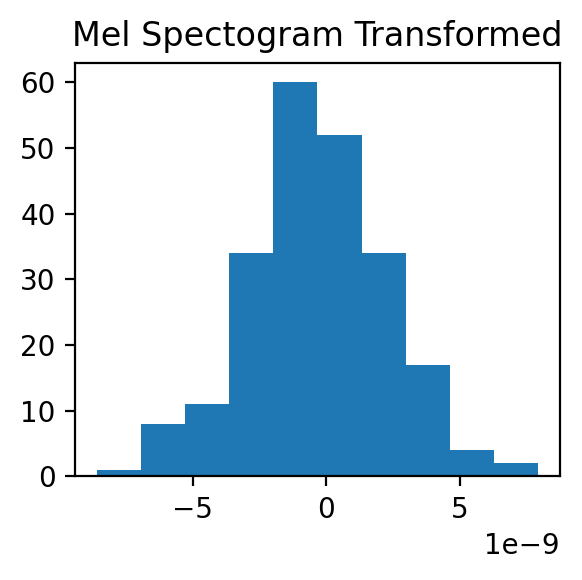

In [41]:
# Get histogram of transformed Mel data
X_mel_log_hist , _ = get_reduced_data(data_std['log mel'][0], 50)

# plot histogram of mel spectogram data
plt.figure(figsize=(3, 3), dpi=200)
plt.hist(X_mel_log_hist)
plt.title('Mel Spectogram Transformed')

plt.tight_layout()
plt.savefig(f"{images_dir}/mel_transformed_hist.pdf")
plt.show()

In [42]:
# Define list of model names for each feature
amp_std = ['std amp']
mel_std = ['log mel']

In [43]:
# Get Amp List of standardized models
'''
models_amp_std_list = {}


for label in amp_std:
  print(label)
  print(data_std[label][0].shape)
  print(data_std[label][1].shape)
  models_amp_std_list['{}'.format(label)] = logit_base.fit(data_std[label][0], data_std[label][1])

# Save model list
with open ("models_amp_std_list", "wb") as f:
  pickle.dump(models_amp_std_list, f)
'''


'\nmodels_amp_std_list = {}\n\n\nfor label in amp_std:\n  print(label)\n  print(data_std[label][0].shape)\n  print(data_std[label][1].shape)\n  models_amp_std_list[\'{}\'.format(label)] = logit_base.fit(data_std[label][0], data_std[label][1])\n\n# Save model list\nwith open ("models_amp_std_list", "wb") as f:\n  pickle.dump(models_amp_std_list, f)\n'

In [44]:
# Get Mel List of standardized models

'''
models_mel_std_list = {}

for label in mel_std:
  print(label)
  print(data_std[label][0].shape)
  print(data_std[label][1].shape)
  models_mel_std_list['{}'.format(label)] = logit_base.fit(data_std[label][0], data_std[label][1])

# Save model list
with open ("models_mel_std_list", "wb") as f:
  pickle.dump(models_mel_std_list, f)
'''



'\nmodels_mel_std_list = {}\n\nfor label in mel_std:\n  print(label)\n  print(data_std[label][0].shape)\n  print(data_std[label][1].shape)\n  models_mel_std_list[\'{}\'.format(label)] = logit_base.fit(data_std[label][0], data_std[label][1])\n\n# Save model list\nwith open ("models_mel_std_list", "wb") as f:\n  pickle.dump(models_mel_std_list, f)\n'

In [45]:
## Calculate Evaluation Metrics

for item in amp_std:
  print(item)
  eval_scores(data_std[item][0], data_std[item][1], data_std[item][2], data_std[item][3], models_amp_std_list[item])

for item in mel_std:
  print(item)
  eval_scores(data_std[item][0], data_std[item][1], data_std[item][2], data_std[item][3], models_mel_std_list[item])



std amp
Train Accuracy:
1.00
Test Accuracy:
0.17
log mel
Train Accuracy:
1.00
Test Accuracy:
0.44


Overall Evaluation Metrics:

Train Accuracy:
1.00
Test Accuracy:
0.44

Per-Class Evaluation Metrics:

AC; Train Accuracy: 1.00; Test Accuracy: 0.23
Car Horn; Train Accuracy: 1.00; Test Accuracy: 0.67
Child; Train Accuracy: 1.00; Test Accuracy: 0.25
Dog; Train Accuracy: 1.00; Test Accuracy: 0.31
Drill; Train Accuracy: 1.00; Test Accuracy: 0.40
Engine; Train Accuracy: 1.00; Test Accuracy: 0.60
Gun; Train Accuracy: 1.00; Test Accuracy: 0.53
Jackhammer; Train Accuracy: 1.00; Test Accuracy: 0.62
Siren; Train Accuracy: 1.00; Test Accuracy: 0.70
Music; Train Accuracy: 1.00; Test Accuracy: 0.45
Micro-averaged One-vs-Rest ROC AUC score:
0.76


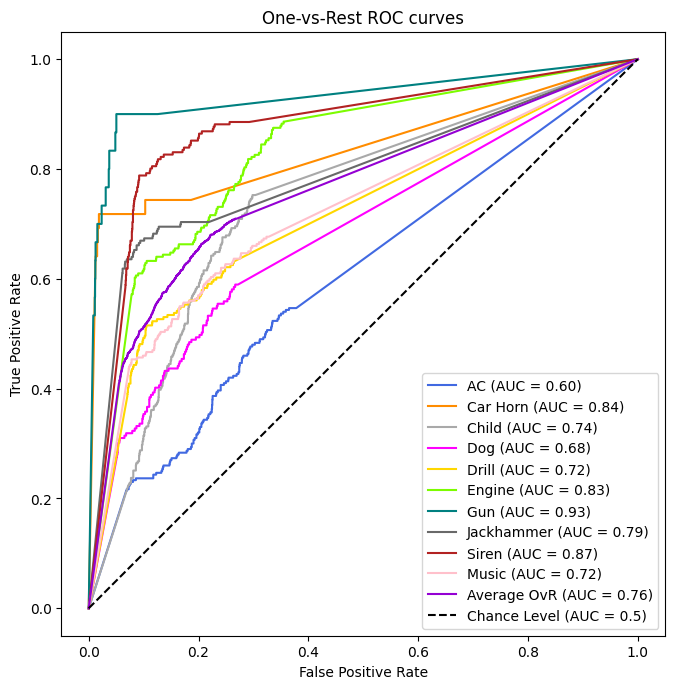

In [46]:
get_results(data_std['log mel'][0], data_std['log mel'][1], data_std['log mel'][2], data_std['log mel'][3], models_mel_std_list['log mel'], 'ROC_mel_spectogram_std')

## Principal Component Analysis


In [47]:
for item, _ in data_std.items():
  print(item)

std amp
log mel


In [48]:
# Define function to return PCA data

def get_pca_data(X_train, X_test, pca_n):
  pca_fit = PCA(n_components = pca_n)
  pca_fit = pca_fit.fit(X_train)
  X_train_pca = pca_fit.transform(X_train)
  X_test_pca = pca_fit.transform(X_test)
  return(X_train_pca, X_test_pca)


In [49]:
# Get PCA data

'''
# use 95% of the variation in the X data
pca_n = 0.95
data_pca = {}

for label, vars in data_std.items():
  X_train_pca, X_test_pca = get_pca_data(data_std[label][0], data_std[label][2], pca_n)
  data_pca[label] = (X_train_pca, vars[1], X_test_pca, vars[3])

# save the PCA data (takes some time to run)
with open (model_dir + "data_pca", "wb") as f:
  pickle.dump(data_pca, f)
'''

'\n# use 95% of the variation in the X data\npca_n = 0.95\ndata_pca = {}\n\nfor label, vars in data_std.items():\n  X_train_pca, X_test_pca = get_pca_data(data_std[label][0], data_std[label][2], pca_n)\n  data_pca[label] = (X_train_pca, vars[1], X_test_pca, vars[3])\n\n# save the PCA data (takes some time to run)\nwith open (model_dir + "data_pca", "wb") as f:\n  pickle.dump(data_pca, f)\n'

In [50]:
# Define function to return PCA Results

def get_pca_results(label, X_train_pca, y_train, X_test_pca, y_test, X_train_std, pca_n):

  # Print Output
  print(f"Data: {label}")
  print(f"No. Components:\n{X_train_pca.shape[1]:.0f}")

  # Initialize figure
  x_inter = X_train_pca.shape[1] # X intercept
  no_row = X_train_std.shape[0] + 1

  pca = PCA().fit(X_train_std)
  xi = np.arange(1, no_row, step=1)
  y = np.cumsum(pca.explained_variance_ratio_)

  ## Plot Figure
  plt.rcParams["figure.figsize"] = (12,6)
  fig, ax = plt.subplots()

  plt.ylim(0.0,1.1)
  plt.plot(xi, y, linestyle='--', color='b')

  plt.xlabel('Number of Components')
  plt.xticks(np.arange(0, no_row, step=1000))  #change from 0-based array index to 1-based human-readable label
  plt.ylabel('Cumulative variance (%)')
  plt.title(f'The number of components needed to explain variance - {label}')

  plt.axhline(y=pca_n, color='r', linestyle='-')
  plt.axvline(x = x_inter, color = 'black', linestyle = '-' )
  plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

  ax.grid(axis='x')
  plt.savefig(f"{images_dir}/pca_analysis_{label}.pdf")
  plt.show()

  ## Train model
  logit_pca = logit_base.fit(X_train_pca, y_train)

  # Calculate Evaluation Metrics
  train_score = logit_pca.score(X_train_pca, y_train)
  test_score = logit_pca.score(X_test_pca, y_test)
  print(f"Train Accuracy:\n{train_score:.2f}")
  print(f"Test Accuracy:\n{test_score:.2f}")


In [51]:

for label, _ in data_pca.items():
  print(label)
  get_pca_results(label, data_pca[label][0], data_pca[label][1], data_pca[label][2], data_pca[label][3], data_std[label][0], pca_n)

std amp


NameError: name 'pca_n' is not defined

## Multinomial Logit - Parameter Tuning

### Mel Spectogram Data - PCA

In [ ]:
print(data_pca['log mel'][0].shape)
print(data_pca['log mel'][1].shape)

(5553, 739)
(5553,)


In [ ]:
# Use GridSearchCV to find optimal penalty and number of learning steps, according to 5-fold cv
params = {'C':[1, 0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0005, 0.0001]}
logit_search = LogisticRegression(fit_intercept=True, penalty = 'l2', multi_class = 'multinomial', max_iter = 3000, solver = 'lbfgs')
logit_search = GridSearchCV(logit_search, params, cv = 5,scoring = 'accuracy')

In [ ]:
'''
# Fit model 
logit_mel_search = logit_search.fit(data_pca['log mel'][0], data_pca['log mel'][1])

# Save model
with open (model_dir + "logit_mel_search", "wb") as f:
  pickle.dump(logit_mel_search, f)
'''

/Users/brentonstefko/opt/anaconda3/envs/homework3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/brentonstefko/opt/anaconda3/envs/homework3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [ ]:
logit_mel_search_results = pd.DataFrame(logit_mel_search.cv_results_).sort_values(by=['rank_test_score'])
logit_mel_search_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,6.217323,0.435713,0.002926,0.000691,0.001,{'C': 0.001},0.405041,0.474347,0.502250,0.497297,0.459459,0.467679,0.034951,1
8,5.404678,1.074761,0.001862,0.000095,0.0005,{'C': 0.0005},0.405941,0.450945,0.489649,0.506306,0.472973,0.465163,0.034822,2
9,4.333221,0.960454,0.003237,0.002130,0.0001,{'C': 0.0001},0.398740,0.434743,0.477948,0.476577,0.486486,0.454899,0.033344,3
6,11.198679,1.414476,0.004377,0.001370,0.01,{'C': 0.01},0.380738,0.461746,0.504950,0.460360,0.387387,0.439036,0.047710,4
5,19.934912,1.017102,0.003965,0.001840,0.1,{'C': 0.1},0.367237,0.439244,0.463546,0.402703,0.336937,0.401933,0.046081,5
4,20.517453,0.224159,0.004196,0.001978,0.25,{'C': 0.25},0.351035,0.423042,0.441944,0.381081,0.317117,0.382844,0.045703,6
3,20.462669,0.079954,0.004514,0.000984,0.5,{'C': 0.5},0.343834,0.417642,0.426643,0.370270,0.315315,0.374741,0.042523,7
1,20.420106,0.196151,0.003912,0.001102,0.9,{'C': 0.9},0.342934,0.414941,0.418542,0.370270,0.305405,0.370419,0.043082,8
0,20.969911,0.770238,0.006964,0.002029,1,{'C': 1},0.343834,0.412241,0.420342,0.369369,0.303604,0.369878,0.043387,9
2,20.762642,0.439117,0.007303,0.004450,0.75,{'C': 0.75},0.341134,0.410441,0.420342,0.363964,0.306306,0.368437,0.042624,10


In [ ]:
# Get the best parameters according to GridSearch
print(logit_mel_search.best_params_)
logit_mel_best_params = logit_mel_search.best_params_
logit_mel_opt_ins = LogisticRegression(penalty = 'l2', fit_intercept=True, multi_class = 'multinomial',
                                   C = logit_mel_best_params['C'], max_iter = 3000, solver = 'lbfgs')

{'C': 0.001}


In [ ]:
'''
# Train Model 
logit_mel_opt = logit_mel_opt_ins.fit(data_pca['log mel'][0], data_pca['log mel'][1])

# Save model
with open (model_dir + "logit_mel_opt", "wb") as f:
  pickle.dump(logit_mel_opt, f)
'''


Overall Evaluation Metrics:

Train Accuracy:
0.74
Test Accuracy:
0.49

Per-Class Evaluation Metrics:

AC; Train Accuracy: 0.72; Test Accuracy: 0.24
Car Horn; Train Accuracy: 0.82; Test Accuracy: 0.67
Child; Train Accuracy: 0.71; Test Accuracy: 0.59
Dog; Train Accuracy: 0.62; Test Accuracy: 0.42
Drill; Train Accuracy: 0.80; Test Accuracy: 0.45
Engine; Train Accuracy: 0.71; Test Accuracy: 0.55
Gun; Train Accuracy: 0.76; Test Accuracy: 0.57
Jackhammer; Train Accuracy: 0.90; Test Accuracy: 0.62
Siren; Train Accuracy: 0.73; Test Accuracy: 0.56
Music; Train Accuracy: 0.69; Test Accuracy: 0.47
Micro-averaged One-vs-Rest ROC AUC score:
0.87


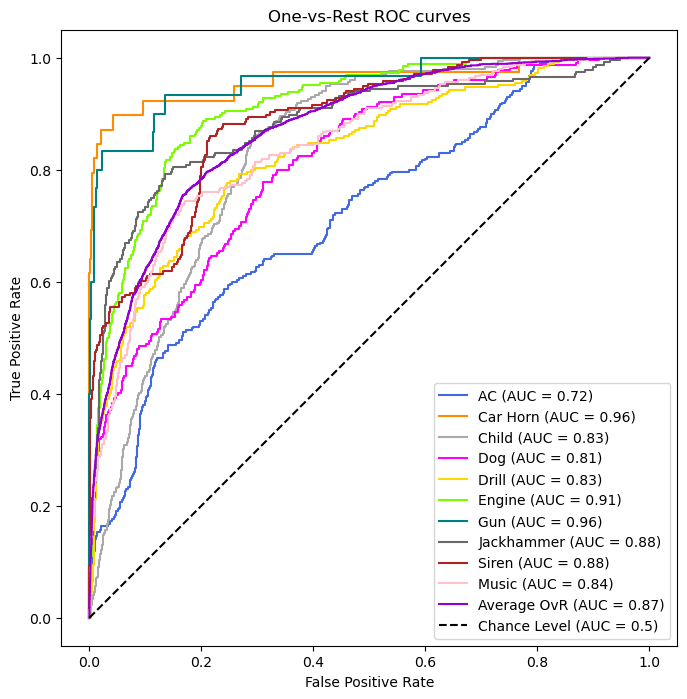

In [ ]:
# get results for optimal model
get_results(data_pca['log mel'][0], data_pca['log mel'][1], data_pca['log mel'][2], data_pca['log mel'][3], logit_mel_opt, 'ROC_logit_mel_opt')

## Training a KNN Model


### Raw Mel Spectogram Data

In [ ]:
knn_base = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
'''
# Calculate base KNN model
knn_mel_base = knn_base.fit(X_mel_train_flat, y_mel_train)

# Save model
with open (model_dir + "knn_mel_base", "wb") as f:
  pickle.dump(knn_mel_base, f)
'''

'\n# Save model\nwith open ("knn_mel_base", "wb") as f:\n  pickle.dump(knn_mel_base, f)\n'

Overall Evaluation Metrics:

Train Accuracy:
0.60
Test Accuracy:
0.27

Per-Class Evaluation Metrics:

AC; Train Accuracy: 0.78; Test Accuracy: 0.17
Car Horn; Train Accuracy: 0.50; Test Accuracy: 0.38
Child; Train Accuracy: 0.47; Test Accuracy: 0.24
Dog; Train Accuracy: 0.41; Test Accuracy: 0.17
Drill; Train Accuracy: 0.67; Test Accuracy: 0.31
Engine; Train Accuracy: 0.88; Test Accuracy: 0.33
Gun; Train Accuracy: 0.66; Test Accuracy: 0.53
Jackhammer; Train Accuracy: 0.82; Test Accuracy: 0.64
Siren; Train Accuracy: 0.50; Test Accuracy: 0.26
Music; Train Accuracy: 0.21; Test Accuracy: 0.06
Micro-averaged One-vs-Rest ROC AUC score:
0.67


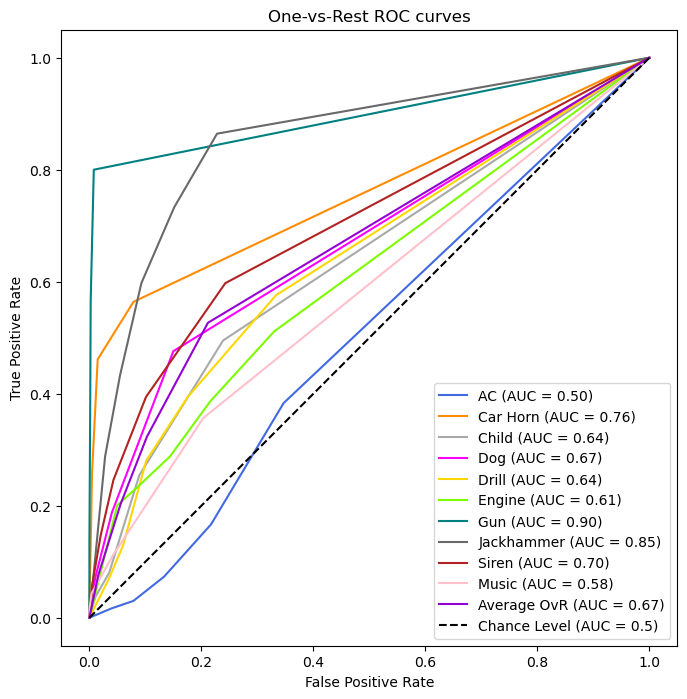

In [ ]:
get_results(X_mel_train_flat, y_mel_train, X_mel_test_flat, y_mel_test, knn_mel_base, 'ROC_knn_base')

### Powertransformed Spectogram Data

In [ ]:

# Calculate base KNN model
knn_mel_std = knn_base.fit(data_std['log mel'][0], data_std['log mel'][1])


# Save model
with open (model_dir + "knn_mel_std", "wb") as f:
  pickle.dump(knn_mel_std, f)


Overall Evaluation Metrics:

Train Accuracy:
0.72
Test Accuracy:
0.41

Per-Class Evaluation Metrics:

AC; Train Accuracy: 0.97; Test Accuracy: 0.43
Car Horn; Train Accuracy: 0.74; Test Accuracy: 0.33
Child; Train Accuracy: 0.45; Test Accuracy: 0.25
Dog; Train Accuracy: 0.52; Test Accuracy: 0.30
Drill; Train Accuracy: 0.90; Test Accuracy: 0.52
Engine; Train Accuracy: 0.94; Test Accuracy: 0.70
Gun; Train Accuracy: 0.87; Test Accuracy: 0.60
Jackhammer; Train Accuracy: 0.94; Test Accuracy: 0.69
Siren; Train Accuracy: 0.69; Test Accuracy: 0.43
Music; Train Accuracy: 0.29; Test Accuracy: 0.07
Micro-averaged One-vs-Rest ROC AUC score:
0.74


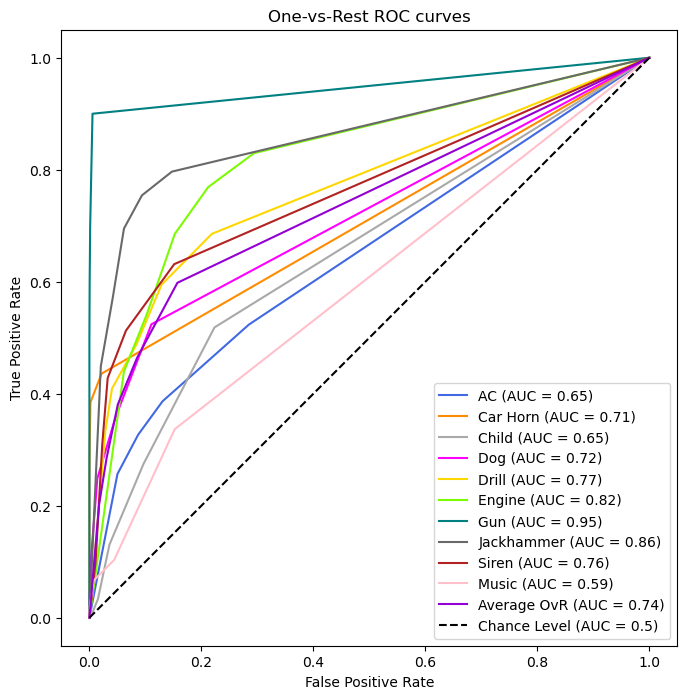

In [ ]:
get_results(data_std['log mel'][0], data_std['log mel'][1], data_std['log mel'][2], data_std['log mel'][3], knn_mel_std, 'ROC_knn_mel_std')

## KNN - Parameter Tuning


### Powertransformed Spectogram Data

In [ ]:
knn_params = {'n_neighbors':[1, 3, 5, 10, 50, 100]}
knn_search = KNeighborsClassifier()
knn_search = GridSearchCV(knn_search, knn_params, cv = 5,scoring = 'accuracy')


In [ ]:

# Fit model 
knn_mel_search = knn_search.fit(data_std['log mel'][0], data_std['log mel'][1])

# Save model
with open (model_dir + "knn_mel_search", "wb") as f:
  pickle.dump(knn_mel_search, f)


In [ ]:
knn_mel_search_results = pd.DataFrame(knn_mel_search.cv_results_).sort_values(by=['rank_test_score'])
knn_mel_search_results.head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106328,0.082921,1.602999,0.062464,1,{'n_neighbors': 1},0.361836,0.603060,0.498650,0.528829,0.420721,0.482619,0.084046,1
1,0.072175,0.003319,1.679796,0.050583,3,{'n_neighbors': 3},0.348335,0.558056,0.453645,0.515315,0.363063,0.447683,0.082246,2
2,0.069709,0.001382,1.755574,0.018011,5,{'n_neighbors': 5},0.333033,0.532853,0.432043,0.509009,0.339640,0.429316,0.082934,3
3,0.072255,0.000754,1.761905,0.036168,10,{'n_neighbors': 10},0.300630,0.472547,0.430243,0.451351,0.322523,0.395459,0.070127,4
5,0.075110,0.001485,1.881361,0.044742,100,{'n_neighbors': 100},0.291629,0.293429,0.285329,0.343243,0.327027,0.308131,0.022796,5
4,0.073563,0.000893,1.812820,0.020989,50,{'n_neighbors': 50},0.270927,0.300630,0.306931,0.339640,0.310811,0.305788,0.021974,6


In [ ]:
# Get the best parameters according to GridSearch
print(knn_mel_search.best_params_)
knn_mel_best_params = knn_mel_search.best_params_
knn_mel_opt_ins = KNeighborsClassifier(n_neighbors = knn_mel_best_params['n_neighbors'])

{'n_neighbors': 1}


In [ ]:
# Train Model

knn_mel_opt = knn_mel_opt_ins.fit(data_std['log mel'][0], data_std['log mel'][1])

# Save model
with open (model_dir + "knn_mel_opt", "wb") as f:
  pickle.dump(knn_mel_opt, f)


Overall Evaluation Metrics:

Train Accuracy:
1.00
Test Accuracy:
0.42

Per-Class Evaluation Metrics:

AC; Train Accuracy: 1.00; Test Accuracy: 0.37
Car Horn; Train Accuracy: 1.00; Test Accuracy: 0.33
Child; Train Accuracy: 1.00; Test Accuracy: 0.17
Dog; Train Accuracy: 1.00; Test Accuracy: 0.33
Drill; Train Accuracy: 1.00; Test Accuracy: 0.55
Engine; Train Accuracy: 1.00; Test Accuracy: 0.72
Gun; Train Accuracy: 1.00; Test Accuracy: 0.77
Jackhammer; Train Accuracy: 1.00; Test Accuracy: 0.68
Siren; Train Accuracy: 1.00; Test Accuracy: 0.49
Music; Train Accuracy: 1.00; Test Accuracy: 0.12
Micro-averaged One-vs-Rest ROC AUC score:
0.68


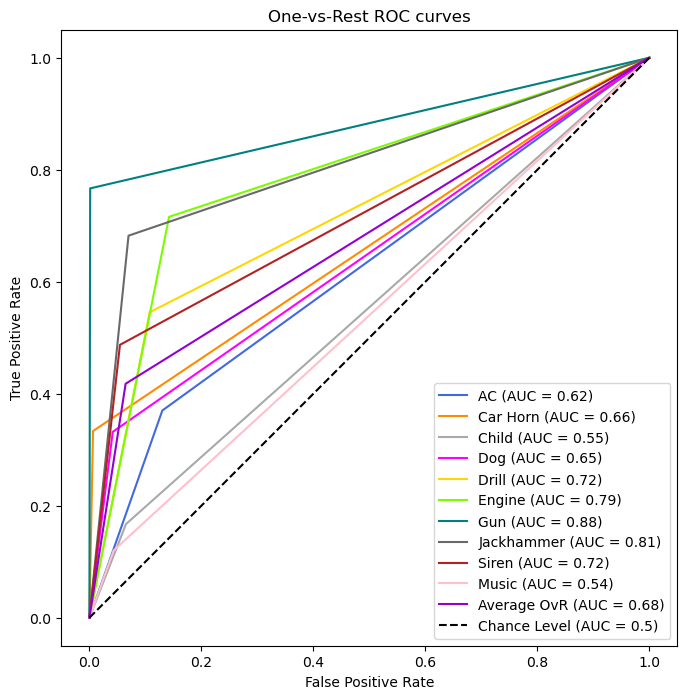

In [ ]:
get_results(data_std['log mel'][0], data_std['log mel'][1], data_std['log mel'][2], data_std['log mel'][3], knn_mel_opt, 'ROC_knn_mel_opt')

## Training a Neural Network


In [55]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [56]:
# get one-hot encoded y matrix

num_labels = np.unique(y_mel_train)
y=np.array(num_labels.tolist())
print(y)

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
print(y)
y.shape

[0 1 2 3 4 5 6 7 8 9]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


(10, 10)

In [57]:
y_mel_train_onehot = to_categorical(labelencoder.fit_transform(y_mel_train))
y_mel_test_onehot = to_categorical(labelencoder.fit_transform(y_mel_test))

print(y_mel_train_onehot)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [58]:
nn_input_shape = X_mel_train_flat.shape[1]
print(nn_input_shape)

11136


In [ ]:
# BASIC NEURAL NETWORK
model=Sequential()
#1.
model.add(Dense(200,input_shape=(nn_input_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#2nd
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#3rd
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#last layer
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2227400   
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               80400     
                                                                 
 activation_1 (Activation)   (None, 400)               0         
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               8

In [ ]:
# Trianing the model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/Users/brentonstefko/Desktop/Harvard/Practical/models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

snn_mel_base = model.fit(X_mel_train_flat, y_mel_train_onehot, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_mel_test_flat, y_mel_test_onehot), callbacks=[checkpointer], verbose=1)

# Save model
with open ("snn_mel_base", "wb") as f:
  pickle.dump(snn_mel_base, f)

duration = datetime.now() - start
print("Training completed in time: ", duration)

# Calculate & Print Scores
# snn_mel_train_score = snn_mel_base.evaluate(X_mel_train_flat ,y_mel_train_onehot,verbose=0)
# print(snn_mel_train_score[1])
# snn_mel_test_score =snn_mel_base.evaluate(X_mel_test_flat ,y_mel_test_onehot,verbose=0)
# print(snn_mel_test_score[1])'


Epoch 1/100
173/174 [============================>.] - ETA: 0s - loss: 1.8734 - accuracy: 0.3544
Epoch 1: val_loss improved from inf to 14.57109, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/audio_classification.hdf5
174/174 [==============================] - 2s 11ms/step - loss: 1.8729 - accuracy: 0.3542 - val_loss: 14.5711 - val_accuracy: 0.3177
Epoch 2/100
173/174 [============================>.] - ETA: 0s - loss: 1.8787 - accuracy: 0.3488
Epoch 2: val_loss did not improve from 14.57109
174/174 [==============================] - 2s 10ms/step - loss: 1.8791 - accuracy: 0.3479 - val_loss: 16.1798 - val_accuracy: 0.3054
Epoch 3/100
169/174 [============================>.] - ETA: 0s - loss: 2.3255 - accuracy: 0.3450
Epoch 3: val_loss did not improve from 14.57109
174/174 [==============================] - 2s 10ms/step - loss: 2.3455 - accuracy: 0.3434 - val_loss: 16.2744 - val_accuracy: 0.3104
Epoch 4/100
171/174 [============================>.] - ETA: 0s - loss

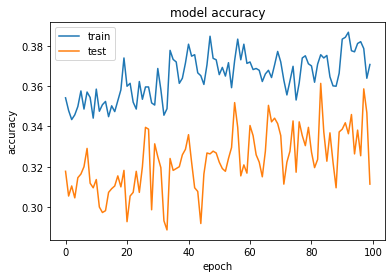

In [ ]:
#Plot Model accuracy over training periods
plt.plot(snn_mel_base.history['accuracy'])
plt.plot(snn_mel_base.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

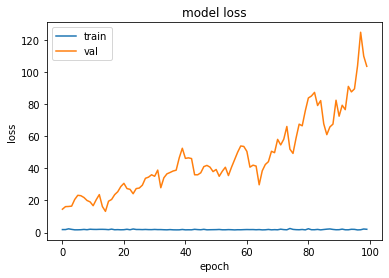

In [ ]:
# Plot Model Loss over training periods
plt.plot(snn_mel_base.history['loss'])
plt.plot(snn_mel_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

To do:
* Train the model using the transformed mel spectogram data

## Training a Convolutional Neural Network

In [52]:
## Treat Mel Spectograms as Greyscale images
print(X_mel_train.shape)

(5553, 128, 87)


In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

In [54]:
# Reshape X_train (must be 4-dimensional)
train_images = X_mel_train.reshape(X_mel_train.shape[0], X_mel_train.shape[1], X_mel_train.shape[2], 1)
test_images = X_mel_test.reshape(X_mel_test.shape[0], X_mel_test.shape[1], X_mel_test.shape[2], 1)
train_images.shape

(5553, 128, 87, 1)

In [ ]:
# Standardize Mel Spectogram Data
def mel_scaler(X_train, X_test):
    mean = X_train.mean()
    sd = X_test.std()
    X_train = (X_train - mean)/sd
    X_test = (X_test - mean)/sd
    return(X_train, X_test)

train_images_std, test_images_std = mel_scaler(train_images, test_images)

In [103]:
# Convolutional NEURAL NETWORK
cnn = Sequential()
cnn.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape=(128, 87, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
cnn.add(Dropout(0.7))
cnn.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
cnn.add(Dropout(0.7))
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dense(10, activation='softmax'))


# cnn.add(Conv2D(128, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D(2, 2))
# cnn.add(Conv2D(128, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D(2, 2))
# cnn.add(Conv2D(128, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D(2, 2))
# cnn.add(Flatten())
# cnn.add(Dense(1024, activation='relu'))
# cnn.add(Dense(10, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 126, 85, 32)       320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 63, 42, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 63, 42, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 61, 40, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 30, 20, 64)      

In [104]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 10
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_2.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

cnn_mel_base = cnn.fit(train_images_std, y_mel_train_onehot, batch_size=num_batch_size, epochs=num_epochs, validation_data=(test_images_std, y_mel_test_onehot), callbacks=[checkpointer], verbose=1)

# Save model
with open ("cnn_mel_base", "wb") as f:
  pickle.dump(cnn_mel_base, f)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 2.2171 - accuracy: 0.2836
Epoch 1: val_loss improved from inf to 2.02776, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_2.hdf5
87/87 [==============================] - 34s 383ms/step - loss: 2.2171 - accuracy: 0.2836 - val_loss: 2.0278 - val_accuracy: 0.2881
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 1.6833 - accuracy: 0.4185
Epoch 2: val_loss improved from 2.02776 to 1.87218, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_2.hdf5
87/87 [==============================] - 32s 365ms/step - loss: 1.6833 - accuracy: 0.4185 - val_loss: 1.8722 - val_accuracy: 0.3509
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 1.5166 - accuracy: 0.4621
Epoch 3: val_loss improved from 1.87218 to 1.79142, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_2.h

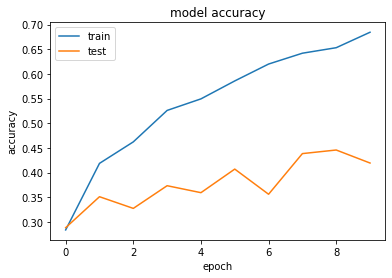

In [105]:
#Plot Model accuracy over training periods
plt.plot(cnn_mel_base.history['accuracy'])
plt.plot(cnn_mel_base.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

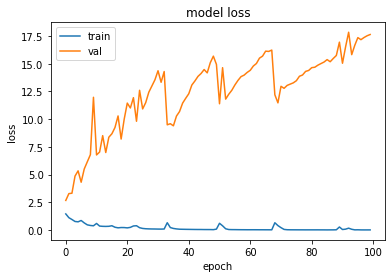

In [66]:
# Plot Model Loss over training periods
plt.plot(cnn_mel_base.history['loss'])
plt.plot(cnn_mel_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
cnn_gamma = Sequential()
cnn_gamma.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 87, 1)))
cnn_gamma.add(MaxPooling2D(2, 2))
cnn_gamma.add(Dropout(0.05))
cnn_gamma.add(Conv2D(128, (3, 3), activation='relu'))
cnn_gamma.add(MaxPooling2D(2, 2))
cnn_gamma.add(Dropout(0.05))
cnn_gamma.add(Conv2D(128, (3, 3), activation='relu'))
cnn_gamma.add(MaxPooling2D(2, 2))
cnn_gamma.add(Dropout(0.05))
cnn_gamma.add(Conv2D(128, (3, 3), activation='relu'))
cnn_gamma.add(MaxPooling2D(2, 2))
cnn_gamma.add(Dropout(0.05))
cnn_gamma.add(Flatten())
cnn_gamma.add(Dense(1024, activation='relu'))
cnn_gamma.add(Dense(10, activation='softmax'))
cnn_gamma.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_gamma.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 85, 32)       320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 42, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 42, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 40, 128)       36992     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 20, 128)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 20, 128)      

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 10
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_beta.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

cnn_gamma_mel_base = cnn_gamma.fit(train_images, y_mel_train_onehot, batch_size=num_batch_size, epochs=num_epochs, validation_data=(test_images, y_mel_test_onehot), callbacks=[checkpointer], verbose=1)

# Save model
with open ("cnn_gamma_mel_base", "wb") as f:
  pickle.dump(cnn_gamma_mel_base, f)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 1.7469 - accuracy: 0.4075
Epoch 1: val_loss improved from inf to 1.97037, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_beta.hdf5
87/87 [==============================] - 34s 389ms/step - loss: 1.7469 - accuracy: 0.4075 - val_loss: 1.9704 - val_accuracy: 0.4301
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 1.4103 - accuracy: 0.5068
Epoch 2: val_loss improved from 1.97037 to 1.89604, saving model to /Users/brentonstefko/Desktop/Harvard/Practical/models/cnn_audio_classification_beta.hdf5
87/87 [==============================] - 37s 422ms/step - loss: 1.4103 - accuracy: 0.5068 - val_loss: 1.8960 - val_accuracy: 0.3814
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 1.2514 - accuracy: 0.5626
Epoch 3: val_loss did not improve from 1.89604
87/87 [==============================] - 40s 458ms/step - loss: 1.2514 - accuracy: 0.5626 - val_l

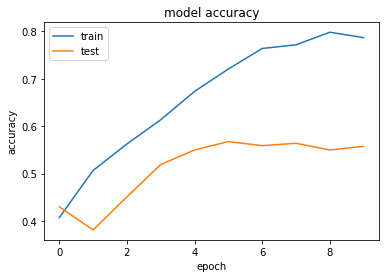

In [79]:
#Plot Model accuracy over training periods
plt.plot(cnn_gamma_mel_base.history['accuracy'])
plt.plot(cnn_gamma_mel_base.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()